# DQN

## Importar Librerias

In [1]:
import gymnasium as gym
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
#from dqn_module import DQNAgent


## Hiperparametros

In [ ]:
GAMMA = 0.99
EPSILON = 1.0
EPSILON_MIN = 0.01
EPSILON_DECAY = 0.995
LEARNING_RATE = 0.001
BATCH_SIZE = 64
MEMORY_SIZE = 2000000 # 400000
EPISODES = 5000 #1000
np.random.seed(123)

## Modelo

In [ ]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.out(x)

In [ ]:
# --- EL AGENTE ---
class DQNAgent:
    def __init__(self, state_size, action_size, 
                 lr=0.001, gamma=0.99, epsilon=1.0, 
                 memory_size=2000, batch_size=32):
        
        self.state_size = state_size
        self.action_size = action_size
        
        # Hiperparámetros guardados en self
        self.gamma = gamma
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        
        # Inicializar modelo y optimizador
        self.model = DQN(state_size, action_size)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        
        # Conversión a Tensor para PyTorch
        # Aseguramos que state sea un array de numpy antes de convertir
        state = np.array(state)
        state_tensor = torch.FloatTensor(state).unsqueeze(0) # Añadir dimensión batch
        
        with torch.no_grad():
            act_values = self.model(state_tensor)
            
        return np.argmax(act_values.numpy())

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        
        # Convertir batch a tensores
        states      = torch.FloatTensor(np.array([t[0] for t in minibatch])).squeeze()
        actions     = torch.LongTensor(np.array([t[1] for t in minibatch])).unsqueeze(1)
        rewards     = torch.FloatTensor(np.array([t[2] for t in minibatch]))
        next_states = torch.FloatTensor(np.array([t[3] for t in minibatch])).squeeze()
        dones       = torch.FloatTensor(np.array([t[4] for t in minibatch]))

        # 1. Calcular Q-values actuales
        curr_Q = self.model(states).gather(1, actions).squeeze()
        
        # 2. Calcular Q-values objetivo (Target)
        with torch.no_grad():
            next_Q = self.model(next_states).max(1)[0]
            expected_Q = rewards + (self.gamma * next_Q * (1 - dones))
        
        # 3. Calcular Pérdida
        loss = self.criterion(curr_Q, expected_Q)
        
        # 4. Optimizar
        self.optimizer.zero_grad() 
        loss.backward()            
        self.optimizer.step()
        return loss.item()

### Entrenamiento

In [2]:
ENV_NAME = "Acrobot-v1"
env = gym.make(ENV_NAME)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size, 
                 lr=LEARNING_RATE, 
                 gamma=GAMMA, 
                 epsilon=EPSILON, 
                 batch_size=BATCH_SIZE,
                 memory_size=MEMORY_SIZE)
)
train_rewards = []
print(f"Entrenando en {ENV_NAME} con PyTorch...")
scores = []
losses_list = []
steps_list = []
epsilons_list = []
for e in range(EPISODES):
    state, _ = env.reset(seed=123)
    
    score = 0
    total_reward=0
    episode_loss=0
    step_count=0
    while True:
        action = agent.act(state)
        
        next_state, reward, done, truncated, _ = env.step(action)
        total_reward += reward
        agent.remember(state, action, reward, next_state, done)
        
        state = next_state
        score += 1
        step_count+= 1

        
        # Acumular el loss que nos devuelve replay
        loss = agent.replay()
        if loss:
            episode_loss += loss
        #agent.replay()

        
        if done or truncated:
            scores.append(score)
            break
    # Al final del episodio, guardamos métricas
    steps_list.append(step_count)
    epsilons_list.append(agent.epsilon)
    # Guardamos el promedio de loss de este episodio
    if step_count > 0:
        losses_list.append(episode_loss / step_count)
    else:
        losses_list.append(0)
    # Decaer Epsilon
    if agent.epsilon > EPSILON_MIN:
        agent.epsilon *= EPSILON_DECAY
    if (e + 1) % 40 == 0:
        print(f"Episodio: {e+1}/{EPISODES}, Pasos: {score}, Epsilon: {agent.epsilon:.2f}")
    train_rewards.append(total_reward)

Entrenando en Acrobot-v1 con PyTorch...
Episodio: 40/5000, Pasos: 500, Epsilon: 0.82
Episodio: 80/5000, Pasos: 331, Epsilon: 0.67
Episodio: 120/5000, Pasos: 274, Epsilon: 0.55
Episodio: 160/5000, Pasos: 131, Epsilon: 0.45
Episodio: 200/5000, Pasos: 151, Epsilon: 0.37
Episodio: 240/5000, Pasos: 130, Epsilon: 0.30
Episodio: 280/5000, Pasos: 155, Epsilon: 0.25
Episodio: 320/5000, Pasos: 114, Epsilon: 0.20
Episodio: 360/5000, Pasos: 117, Epsilon: 0.16
Episodio: 400/5000, Pasos: 85, Epsilon: 0.13
Episodio: 440/5000, Pasos: 119, Epsilon: 0.11
Episodio: 480/5000, Pasos: 99, Epsilon: 0.09
Episodio: 520/5000, Pasos: 86, Epsilon: 0.07
Episodio: 560/5000, Pasos: 91, Epsilon: 0.06
Episodio: 600/5000, Pasos: 100, Epsilon: 0.05
Episodio: 640/5000, Pasos: 105, Epsilon: 0.04
Episodio: 680/5000, Pasos: 77, Epsilon: 0.03
Episodio: 720/5000, Pasos: 109, Epsilon: 0.03
Episodio: 760/5000, Pasos: 75, Epsilon: 0.02
Episodio: 800/5000, Pasos: 110, Epsilon: 0.02
Episodio: 840/5000, Pasos: 88, Epsilon: 0.01
Epi

## Resultados DQN 64 Neuronas - 1K Episodios

In [20]:
# Guardar solo los pesos en un archivo .pth
torch.save(agent.model.state_dict(), "acrobot_dqn_25-12-1k-64N.pth")
print("¡Modelo guardado exitosamente!")

¡Modelo guardado exitosamente!


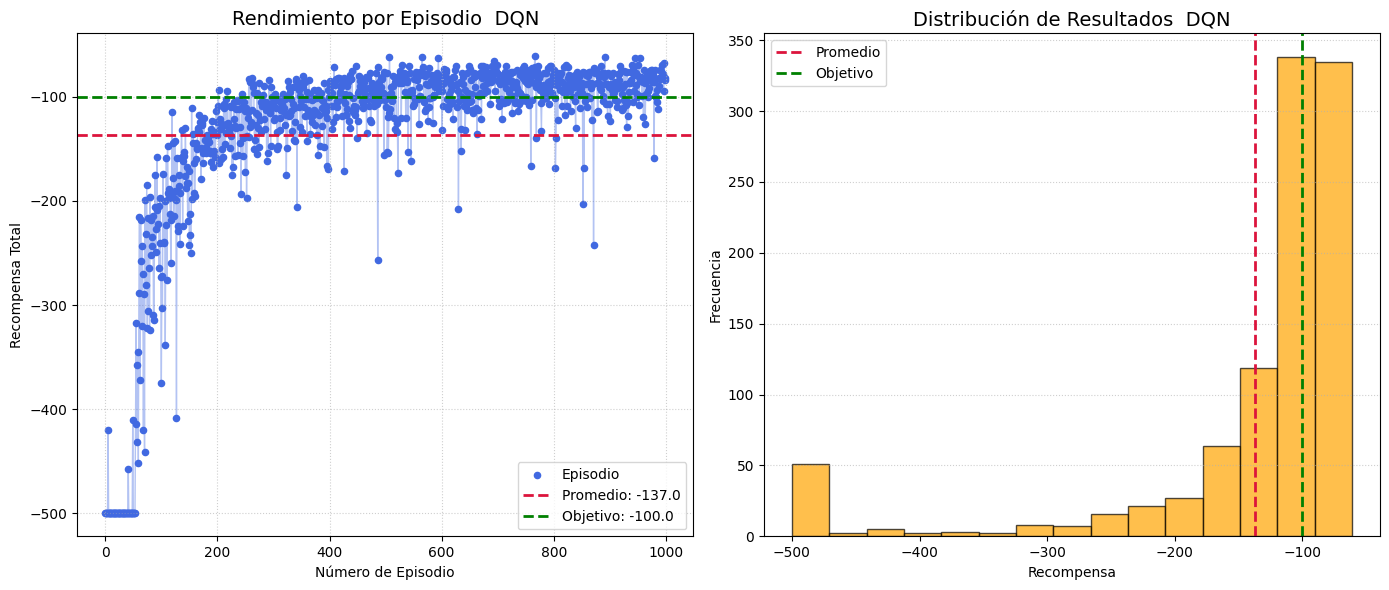

In [21]:
from visualizer import plot_training_results, plot_learning_curve

# OPCIÓN A: El resumen completo (Histograma + Evolución)
plot_training_results(train_rewards, target=-100 , title="DQN")


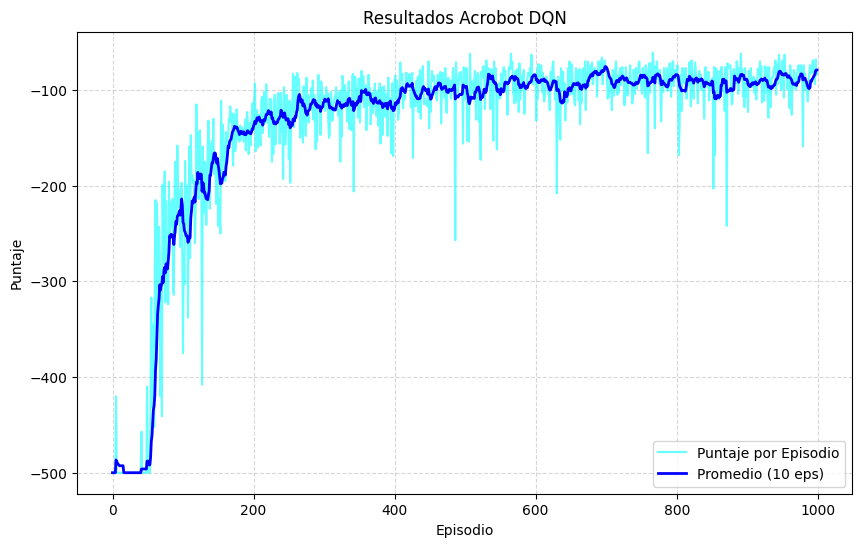

In [22]:
# OPCIÓN B: La curva de aprendizaje clásica (la nueva función)
plot_learning_curve(train_rewards, window_size=10, title="Resultados Acrobot DQN")

## Resultados  DQN 64 Neurona - 3K Episodios

In [9]:
# Guardar solo los pesos en un archivo .pth
torch.save(agent.model.state_dict(), "acrobot_dqn_25-12-3k-64N.pth")
print("¡Modelo guardado exitosamente!")

¡Modelo guardado exitosamente!


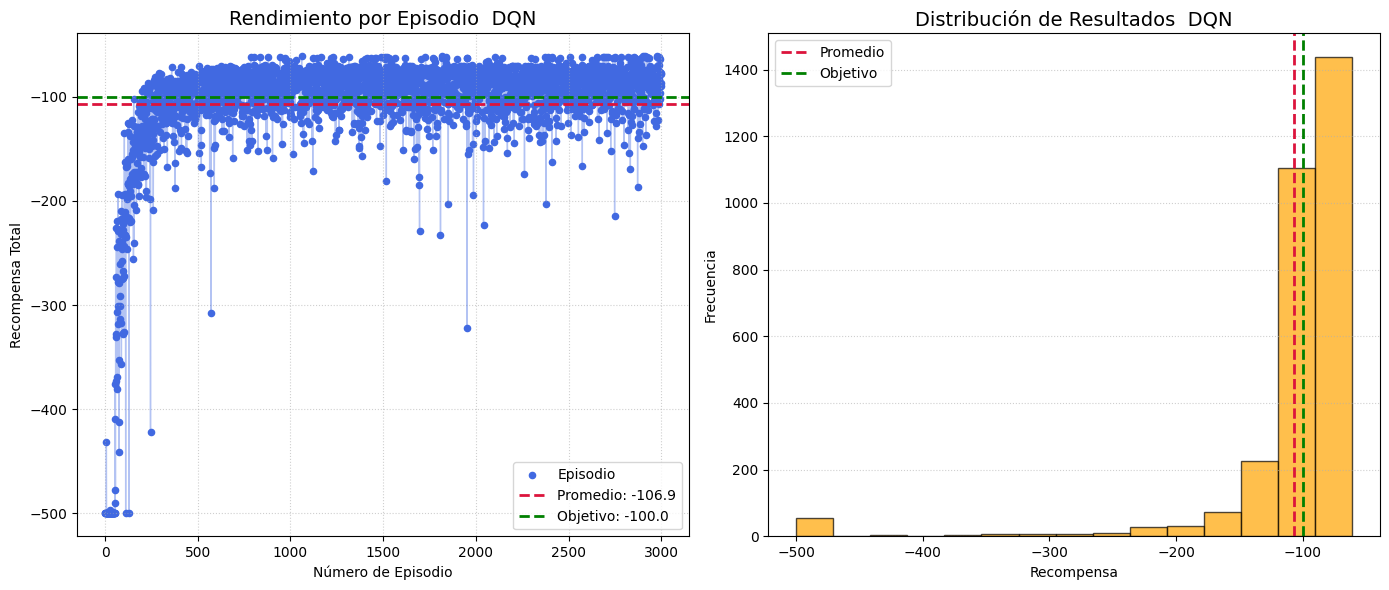

In [3]:
from visualizer import plot_training_results, plot_learning_curve

# OPCIÓN A: El resumen completo (Histograma + Evolución)
plot_training_results(train_rewards, target=-100 , title="DQN")

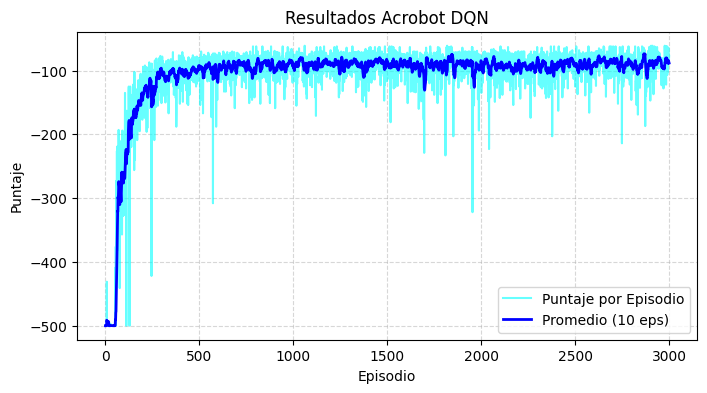

In [8]:
# OPCIÓN B: La curva de aprendizaje clásica (la nueva función)
plot_learning_curve(train_rewards, window_size=10, title="Resultados Acrobot DQN")

In [6]:
np.max(train_rewards)

-61.0

In [3]:
# Guardar solo los pesos en un archivo .pth
torch.save(agent.model.state_dict(), "acrobot_dqn_25-12-3k-128N.pth")
print("¡Modelo guardado exitosamente!")

¡Modelo guardado exitosamente!


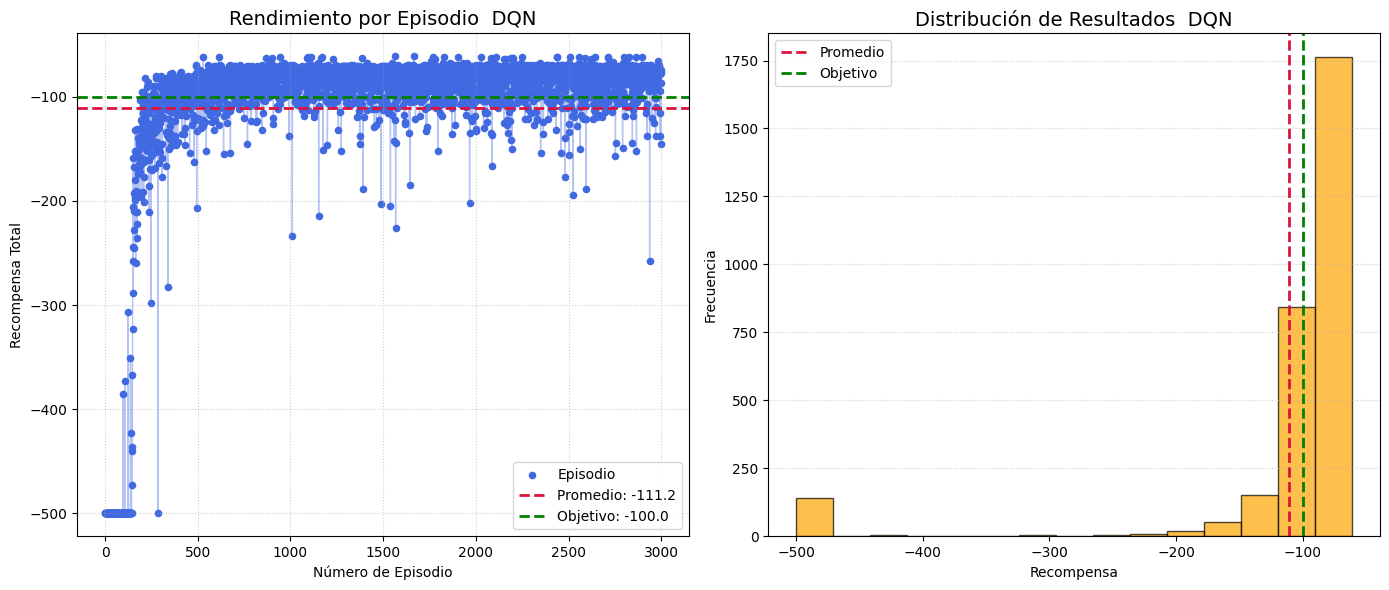

In [4]:
from visualizer import plot_training_results, plot_learning_curve

# OPCIÓN A: El resumen completo (Histograma + Evolución)
plot_training_results(train_rewards, target=-100 , title="DQN")

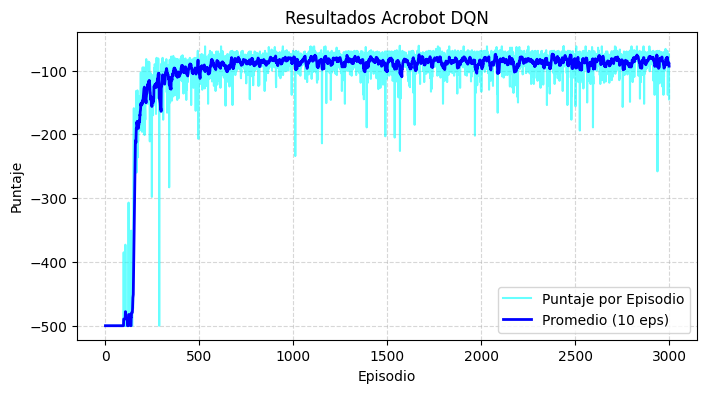

In [5]:
# OPCIÓN B: La curva de aprendizaje clásica (la nueva función)
plot_learning_curve(train_rewards, window_size=10, title="Resultados Acrobot DQN")

## Resultados  DQN 64 Neuronas - 5K Episodios

In [7]:
# Guardar solo los pesos en un archivo .pth
torch.save(agent.model.state_dict(), "acrobot_dqn_25-12-5k-64N.pth")
print("¡Modelo guardado exitosamente!")

¡Modelo guardado exitosamente!


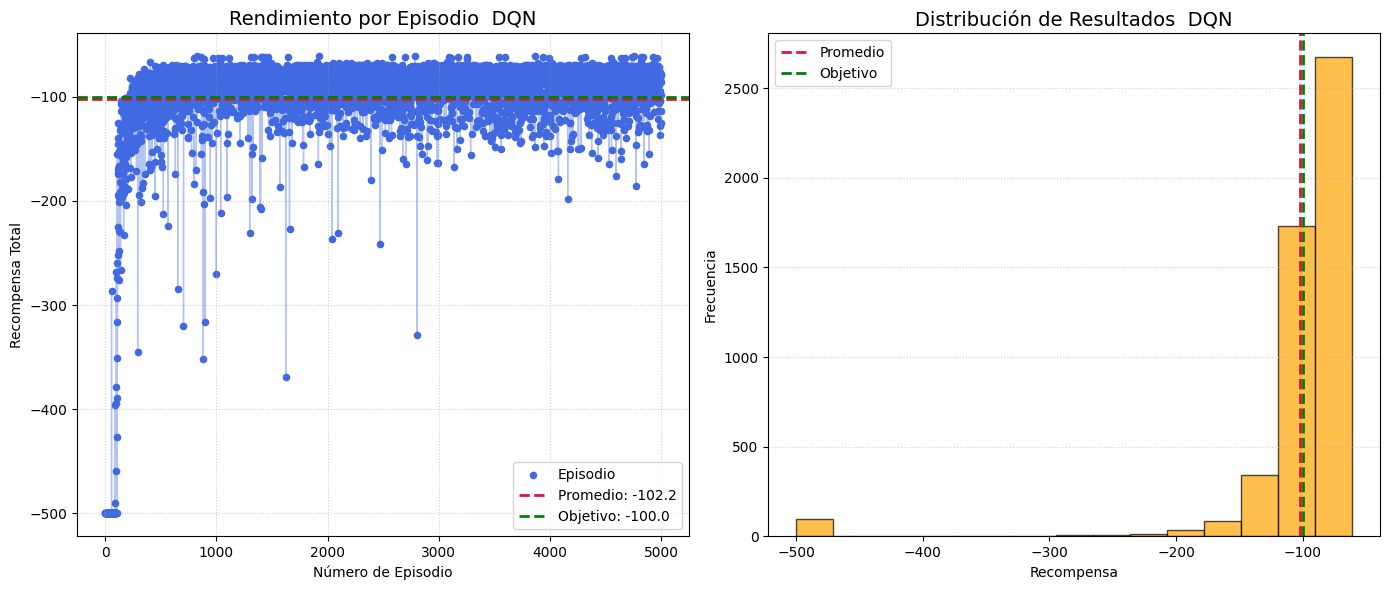

In [3]:
from visualizer import plot_training_results, plot_learning_curve

# OPCIÓN A: El resumen completo (Histograma + Evolución)
plot_training_results(train_rewards, target=-100 , title="DQN")

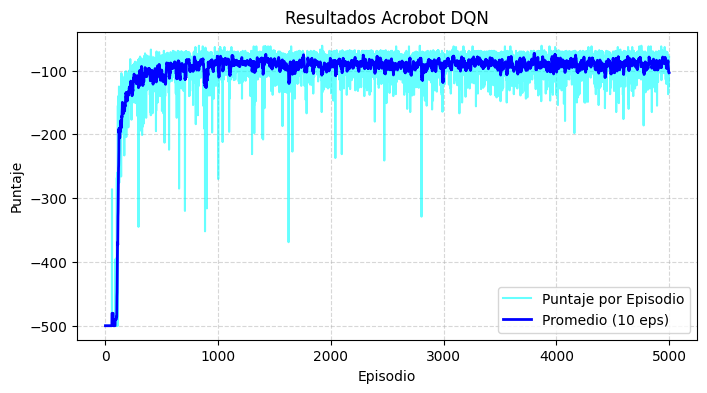

In [4]:
# OPCIÓN B: La curva de aprendizaje clásica (la nueva función)
plot_learning_curve(train_rewards, window_size=10, title="Resultados Acrobot DQN")

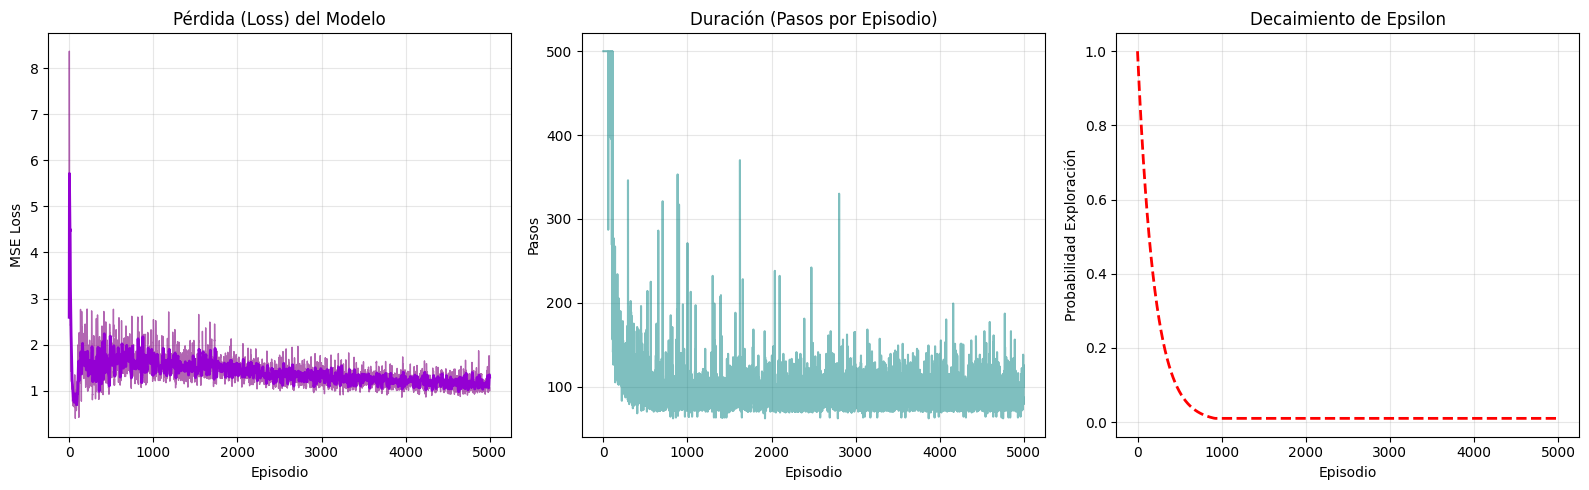

In [5]:
# --- AL FINALIZAR ---
from visualizer import plot_advanced_metrics
plot_advanced_metrics(losses_list, steps_list, epsilons_list)

-62.0

In [7]:
# Guardar solo los pesos en un archivo .pth
torch.save(agent.model.state_dict(), "acrobot_dqn_25-12-1k-128N.pth")
print("¡Modelo guardado exitosamente!")

¡Modelo guardado exitosamente!


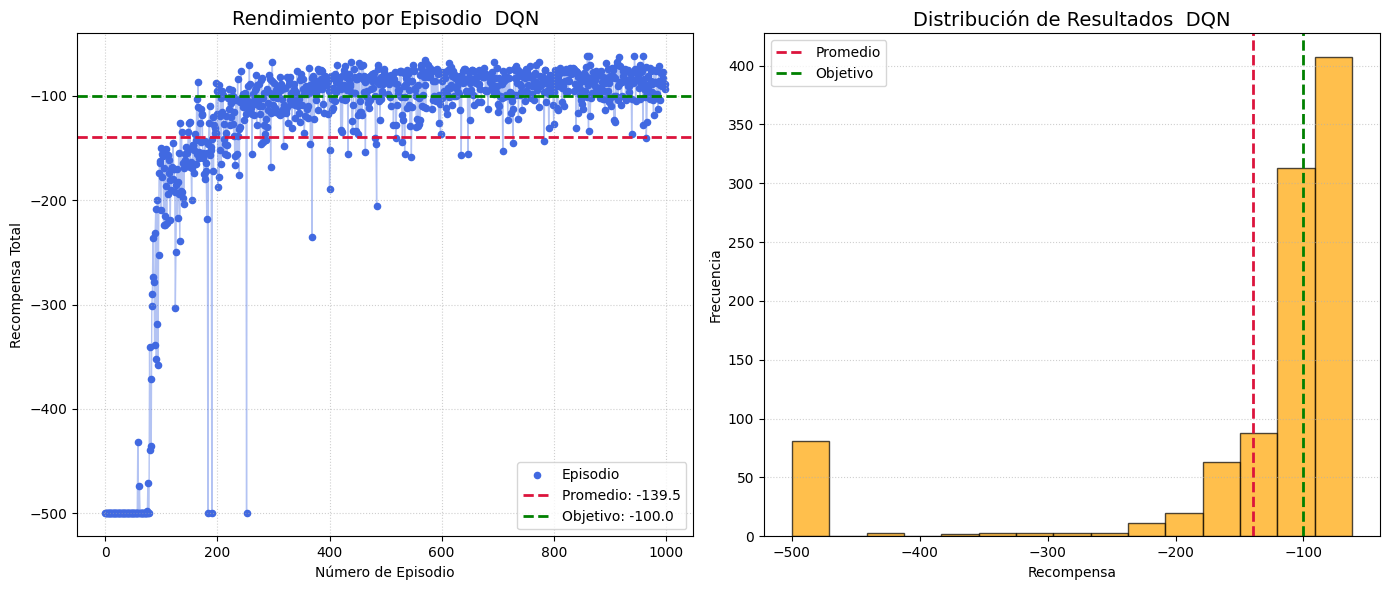

In [3]:
from visualizer import plot_training_results, plot_learning_curve

# OPCIÓN A: El resumen completo (Histograma + Evolución)
plot_training_results(train_rewards, target=-100 , title="DQN")

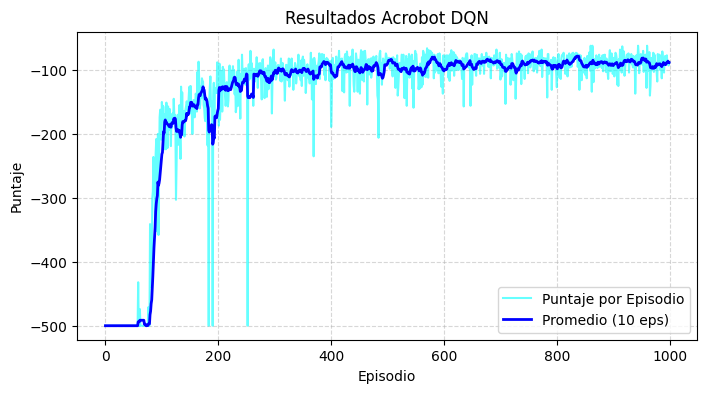

In [4]:
# OPCIÓN B: La curva de aprendizaje clásica (la nueva función)
plot_learning_curve(train_rewards, window_size=10, title="Resultados Acrobot DQN")

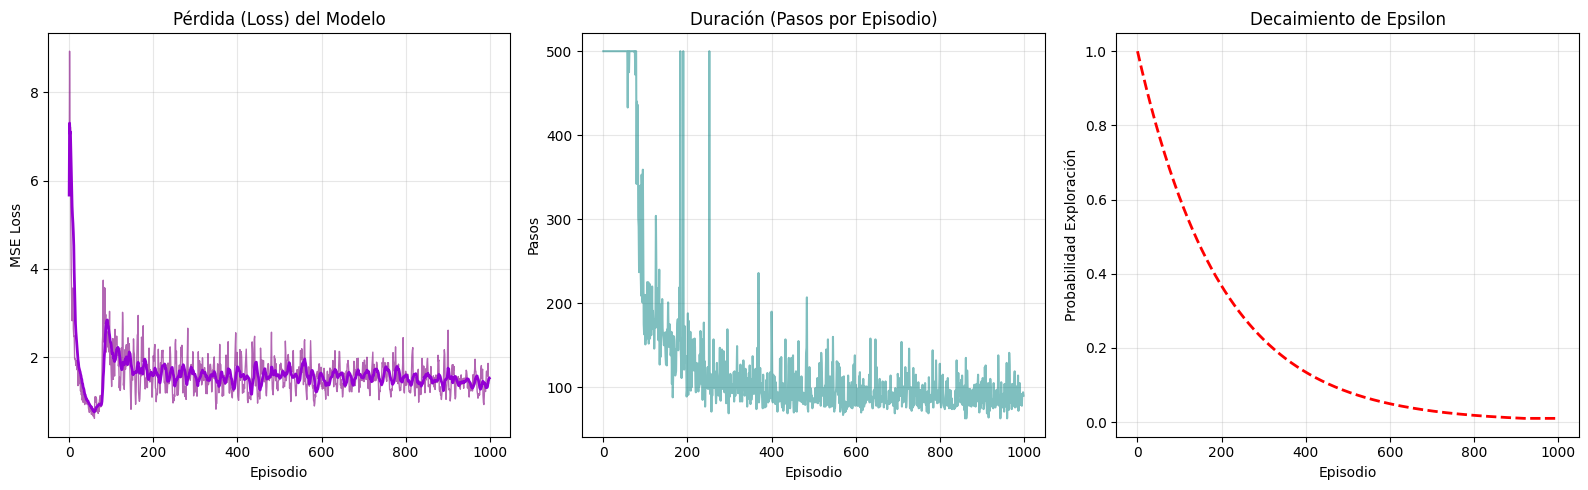

In [5]:
# --- AL FINALIZAR ---
from visualizer import plot_advanced_metrics
plot_advanced_metrics(losses_list, steps_list, epsilons_list)

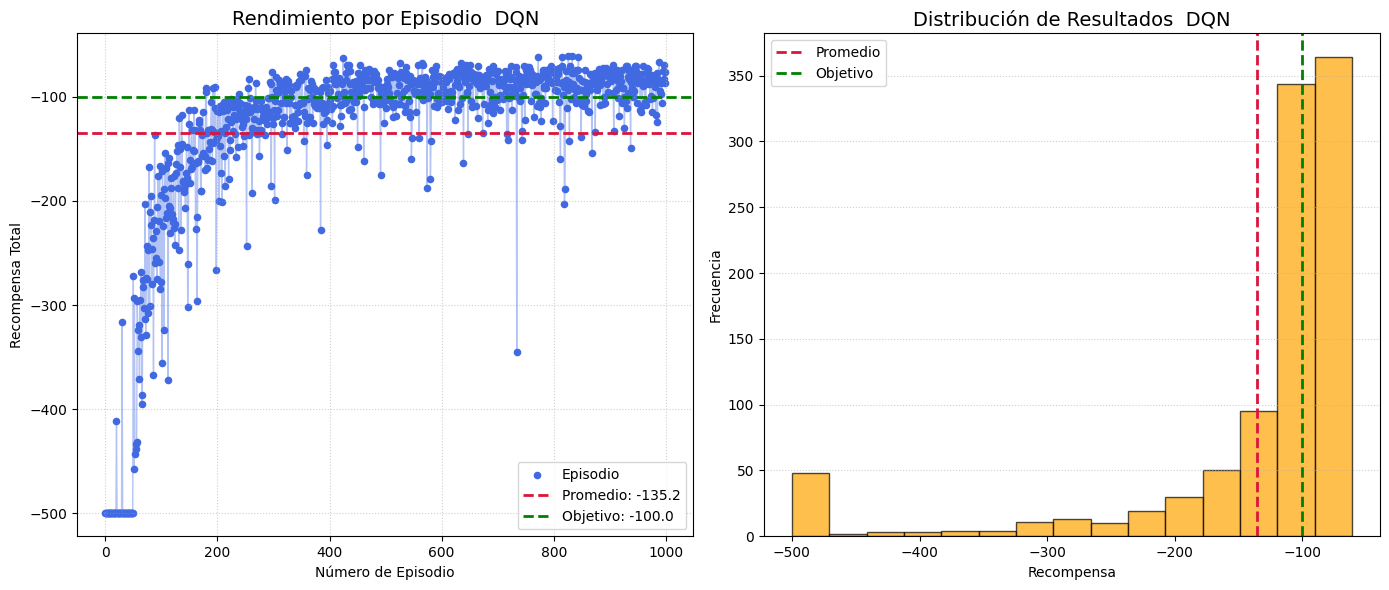

In [3]:
from visualizer import plot_training_results, plot_learning_curve

# OPCIÓN A: El resumen completo (Histograma + Evolución)
plot_training_results(train_rewards, target=-100 , title="DQN")

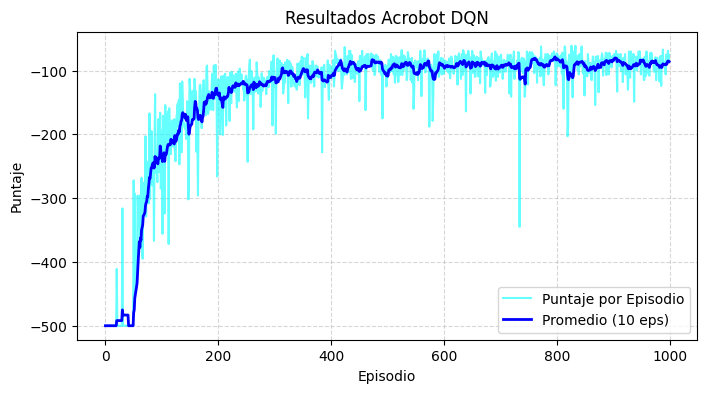

In [4]:
# OPCIÓN B: La curva de aprendizaje clásica (la nueva función)
plot_learning_curve(train_rewards, window_size=10, title="Resultados Acrobot DQN")

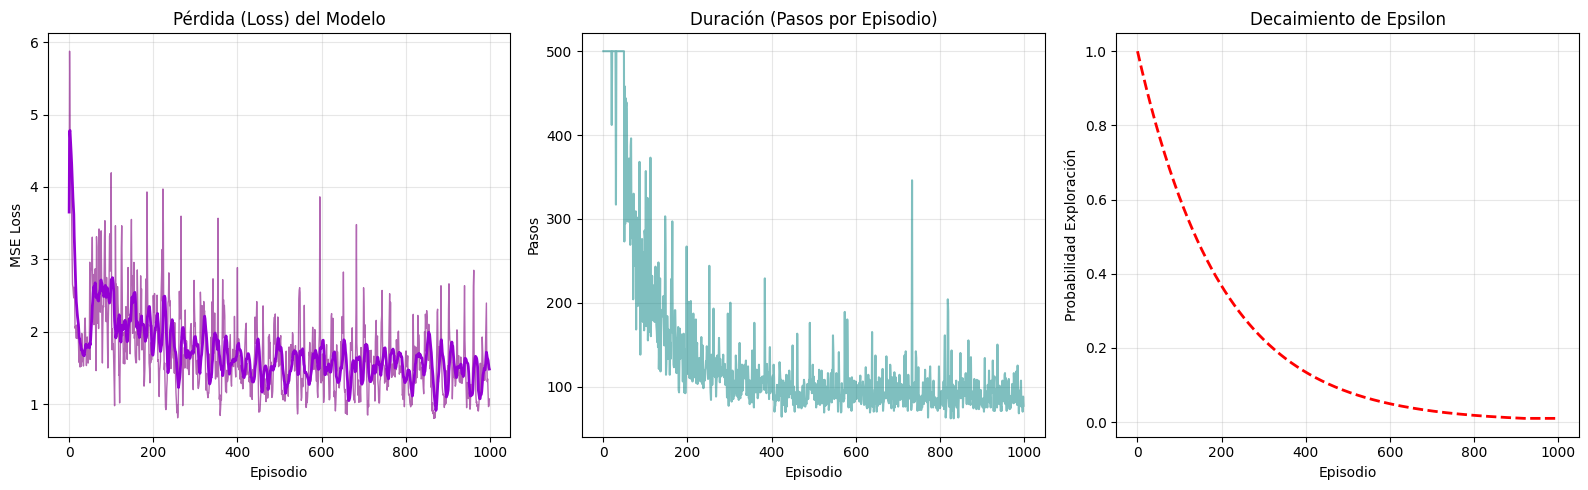

In [5]:
# --- AL FINALIZAR ---
from visualizer import plot_advanced_metrics
plot_advanced_metrics(losses_list, steps_list, epsilons_list)

In [6]:
# Guardar solo los pesos en un archivo .pth
torch.save(agent.model.state_dict(), "acrobot_dqn_25-12-5k-128N.pth")
print("¡Modelo guardado exitosamente!")

¡Modelo guardado exitosamente!


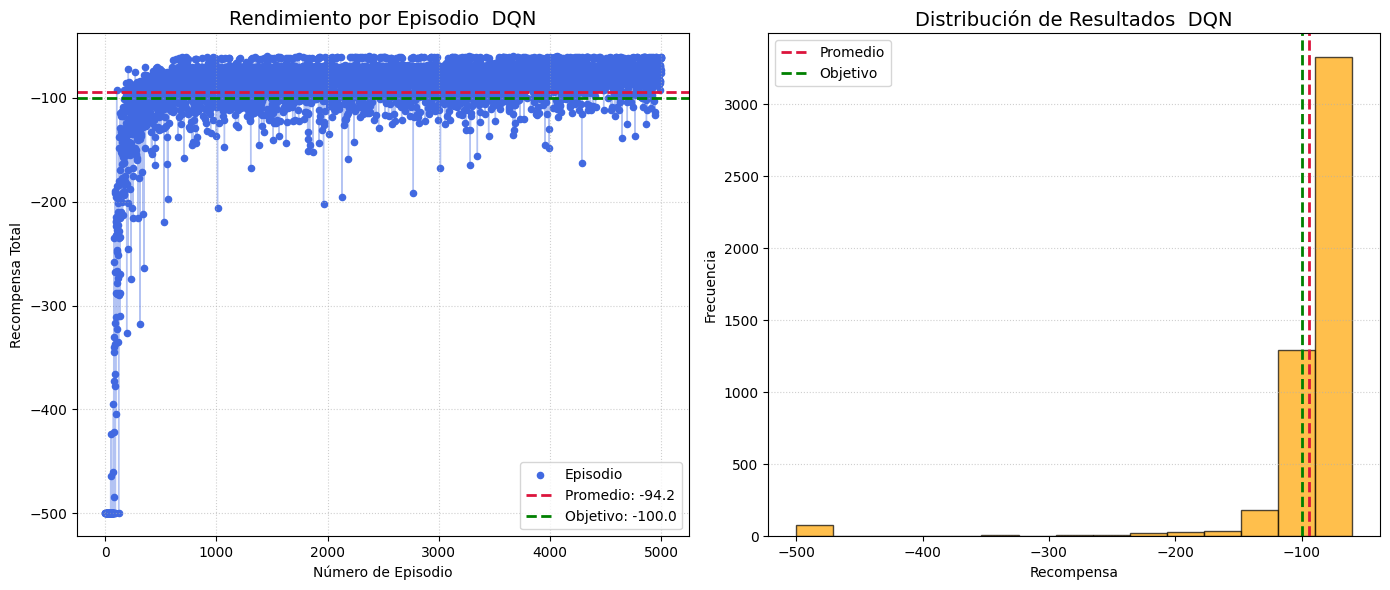

In [3]:
from visualizer import plot_training_results, plot_learning_curve

# OPCIÓN A: El resumen completo (Histograma + Evolución)
plot_training_results(train_rewards, target=-100 , title="DQN")

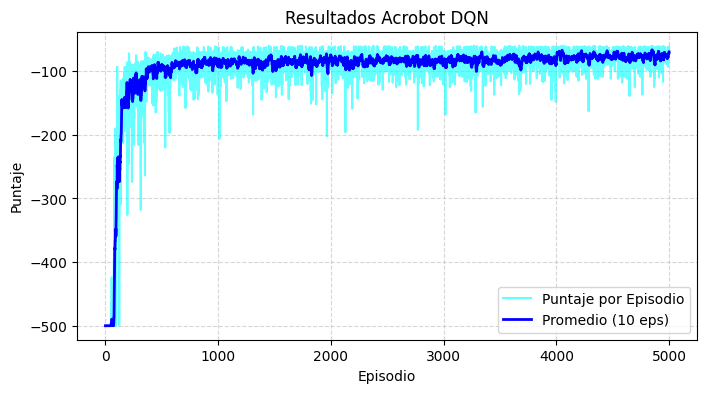

In [4]:
# OPCIÓN B: La curva de aprendizaje clásica (la nueva función)
plot_learning_curve(train_rewards, window_size=10, title="Resultados Acrobot DQN")

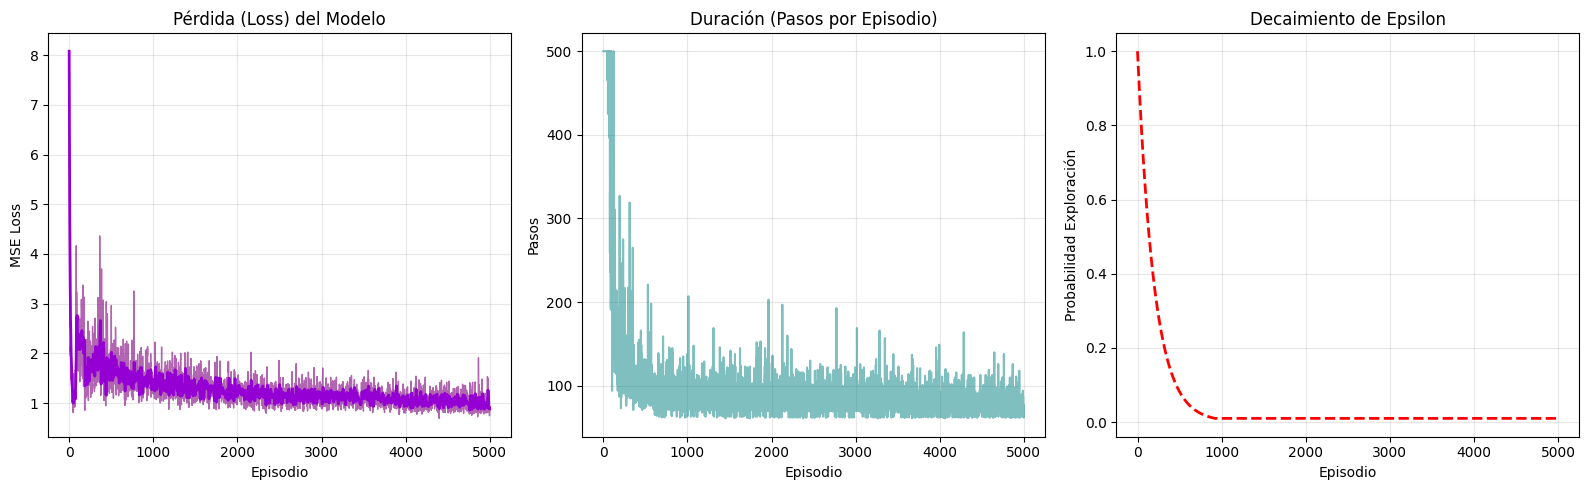

In [5]:
# --- AL FINALIZAR ---
from visualizer import plot_advanced_metrics
plot_advanced_metrics(losses_list, steps_list, epsilons_list)

# Double DQN 

La actualizacion del target se tiene que realizar en todos los episodios para llegar al optimo  

In [2]:
import gymnasium as gym
import time
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
#from ddqn_module import DQNAgent
# --- CONFIGURACIÓN ---
ENV_NAME = "Acrobot-v1"
np.random.seed(123)

## Hiperparametros

In [3]:
GAMMA = 0.99
EPSILON = 1.0
EPSILON_MIN = 0.01
EPSILON_DECAY = 0.995
LEARNING_RATE = 0.001 #0.001  1e-4
BATCH_SIZE = 64
MEMORY_SIZE = 2000000 # 400000
EPISODES = 5000 #1000

## Modelo

In [4]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.out(x)

In [5]:
# --- EL AGENTE ---
class DQNAgent:
    def __init__(self, state_size, action_size, 
                 lr=0.001, gamma=0.99, epsilon=1.0, 
                 memory_size=2000, batch_size=32):
        
        self.state_size = state_size
        self.action_size = action_size
        
        # Hiperparámetros guardados en self
        self.gamma = gamma
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        
        # Inicializar modelo y optimizador
        self.model = DQN(state_size, action_size)
        self.target_model = DQN(state_size, action_size)
        
        # Copiamos los pesos iniciales para que empiecen iguales
        self.update_target_model()       
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
    def update_target_model(self):
        # Copia los pesos de la red principal a la objetivo
        self.target_model.load_state_dict(self.model.state_dict())
        
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        
        # Conversión a Tensor para PyTorch
        # Aseguramos que state sea un array de numpy antes de convertir
        state = np.array(state)
        state_tensor = torch.FloatTensor(state).unsqueeze(0) # Añadir dimensión batch
        
        with torch.no_grad():
            act_values = self.model(state_tensor)
            
        return np.argmax(act_values.numpy())

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        
        # Convertir batch a tensores
        states      = torch.FloatTensor(np.array([t[0] for t in minibatch])).squeeze()
        actions     = torch.LongTensor(np.array([t[1] for t in minibatch])).unsqueeze(1)
        rewards     = torch.FloatTensor(np.array([t[2] for t in minibatch]))
        next_states = torch.FloatTensor(np.array([t[3] for t in minibatch])).squeeze()
        dones       = torch.FloatTensor(np.array([t[4] for t in minibatch]))

        # --- Lógica de entrenamiento ---
        
        # 1. Calcular Q-values actuales
        # gather(1, actions) extrae el Q-value solo de la acción que se tomó
        curr_Q = self.model(states).gather(1, actions).squeeze()
        
        # 2. Calcular Q-values objetivo (Target)
        with torch.no_grad():
            # Argmax nos da el índice (0, 1, 2)
            next_actions = self.model(next_states).argmax(dim=1, keepdim=True)
            #   EVALUACIÓN: La Red Objetivo dice CUÁNTO vale esa acción
            target_values = self.target_model(next_states)
            # Extraemos el valor Q de la acción elegida arriba
            future_q = target_values.gather(1, next_actions).squeeze()
            # 3. CÁLCULO: Ecuación de Bellman con el valor corregido
            expected_Q = rewards + (self.gamma * future_q * (1 - dones))
        
        # 3. Calcular Pérdida
        loss = self.criterion(curr_Q, expected_Q)
        
        # 4. Optimizar
        self.optimizer.zero_grad() 
        loss.backward()            
        self.optimizer.step()
        return loss.item()

## Entrenamiento

In [6]:
# --- BUCLE PRINCIPAL (Igual que antes) ---
env = gym.make(ENV_NAME)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size, 
                 lr=LEARNING_RATE, 
                 gamma=GAMMA, 
                 epsilon=EPSILON, 
                 batch_size=BATCH_SIZE,
                 memory_size=MEMORY_SIZE)
#agent = DQNAgent(state_size, action_size)
train_rewards = []
print(f"Entrenando en {ENV_NAME} con PyTorch...")
scores = []
losses_list = []
steps_list = []
epsilons_list = []
start_time = time.time()
for e in range(EPISODES):
    state, _ = env.reset(seed=123)
    # En PyTorch a veces no necesitamos el reshape [1, state_size] aquí si el agente lo maneja,
    # pero para consistencia con Keras podemos mantener el estado limpio.
    # Aquí lo pasamos "plano" y dejamos que act() haga el unsqueeze.
    
    score = 0
    total_reward=0
    episode_loss=0
    step_count=0

    done = False
    truncated = False

    while not (done or truncated):
        action = agent.act(state)
        next_state, reward, done, truncated, _ = env.step(action)
        
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        score += reward # En Acrobot es -1 por paso
        total_reward += reward
        step_count+=1
        loss = agent.replay()
        if loss:
            episode_loss += loss
        
    # Al final del episodio, guardamos métricas
    steps_list.append(step_count)
    epsilons_list.append(agent.epsilon)
    # Guardamos el promedio de loss de este episodio
    if step_count > 0:
        losses_list.append(episode_loss / step_count)
    else:
        losses_list.append(0)
    # Decaer Epsilon
    if agent.epsilon > EPSILON_MIN:
        agent.epsilon *= EPSILON_DECAY
    #if (e + 1) % 2 == 0:
    #    agent.update_target_model()
    agent.update_target_model()    
    if (e + 1) % 20 == 0:
        # Calcular tiempo transcurrido
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Episodio: {e+1}/{EPISODES}, Pasos: {score}, Epsilon: {agent.epsilon:.2f}, Tiempo 20 eps: {elapsed_time:.2f}s")
        # Reiniciar el cronómetro para los siguientes 20
        start_time = time.time()
    train_rewards.append(total_reward)

Entrenando en Acrobot-v1 con PyTorch...
Episodio: 20/5000, Pasos: -500.0, Epsilon: 0.90, Tiempo 20 eps: 35.89s
Episodio: 40/5000, Pasos: -254.0, Epsilon: 0.82, Tiempo 20 eps: 31.62s
Episodio: 60/5000, Pasos: -300.0, Epsilon: 0.74, Tiempo 20 eps: 26.51s
Episodio: 80/5000, Pasos: -274.0, Epsilon: 0.67, Tiempo 20 eps: 16.85s
Episodio: 100/5000, Pasos: -224.0, Epsilon: 0.61, Tiempo 20 eps: 16.26s
Episodio: 120/5000, Pasos: -162.0, Epsilon: 0.55, Tiempo 20 eps: 11.80s
Episodio: 140/5000, Pasos: -178.0, Epsilon: 0.50, Tiempo 20 eps: 11.62s
Episodio: 160/5000, Pasos: -135.0, Epsilon: 0.45, Tiempo 20 eps: 11.10s
Episodio: 180/5000, Pasos: -163.0, Epsilon: 0.41, Tiempo 20 eps: 9.66s
Episodio: 200/5000, Pasos: -94.0, Epsilon: 0.37, Tiempo 20 eps: 10.00s


KeyboardInterrupt: 

# Double DQN 64 N - 1K Episodios

In [6]:
# Guardar solo los pesos en un archivo .pth
torch.save(agent.model.state_dict(), "acrobot_ddqn_25-12-1k-64N-2.pth")
print("¡Modelo guardado exitosamente!")

¡Modelo guardado exitosamente!


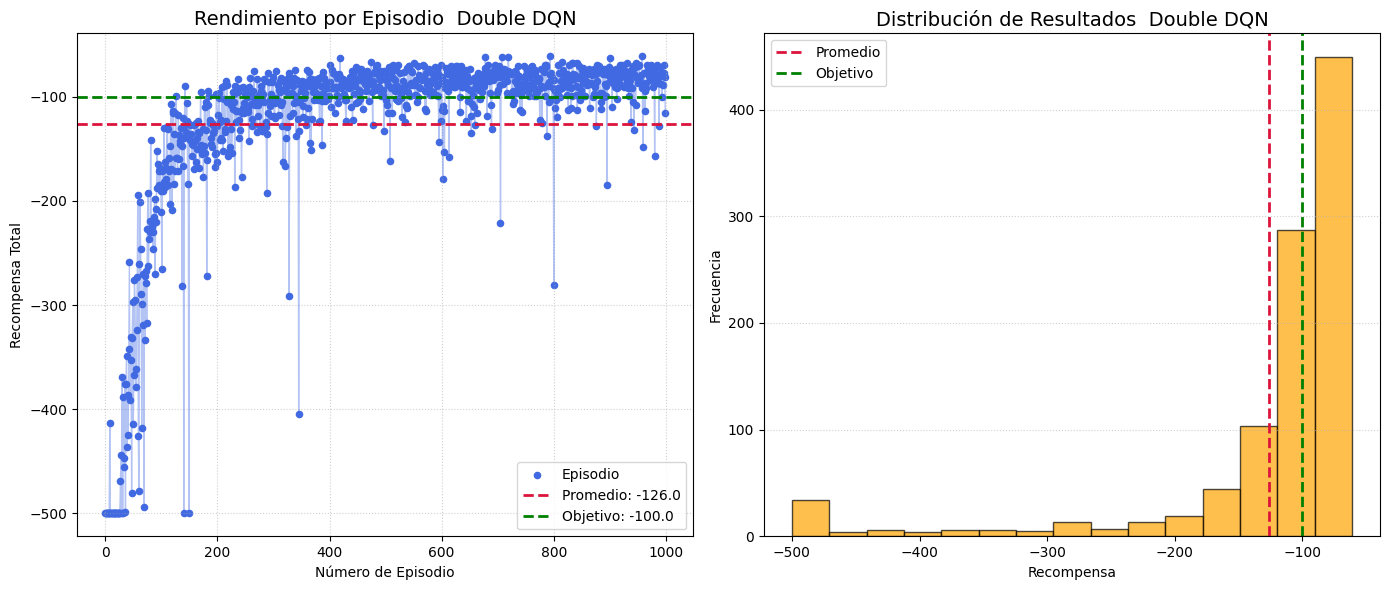

In [3]:
from visualizer import plot_training_results, plot_learning_curve

# OPCIÓN A: El resumen completo (Histograma + Evolución)
plot_training_results(train_rewards, target=-100 , title="Double DQN")

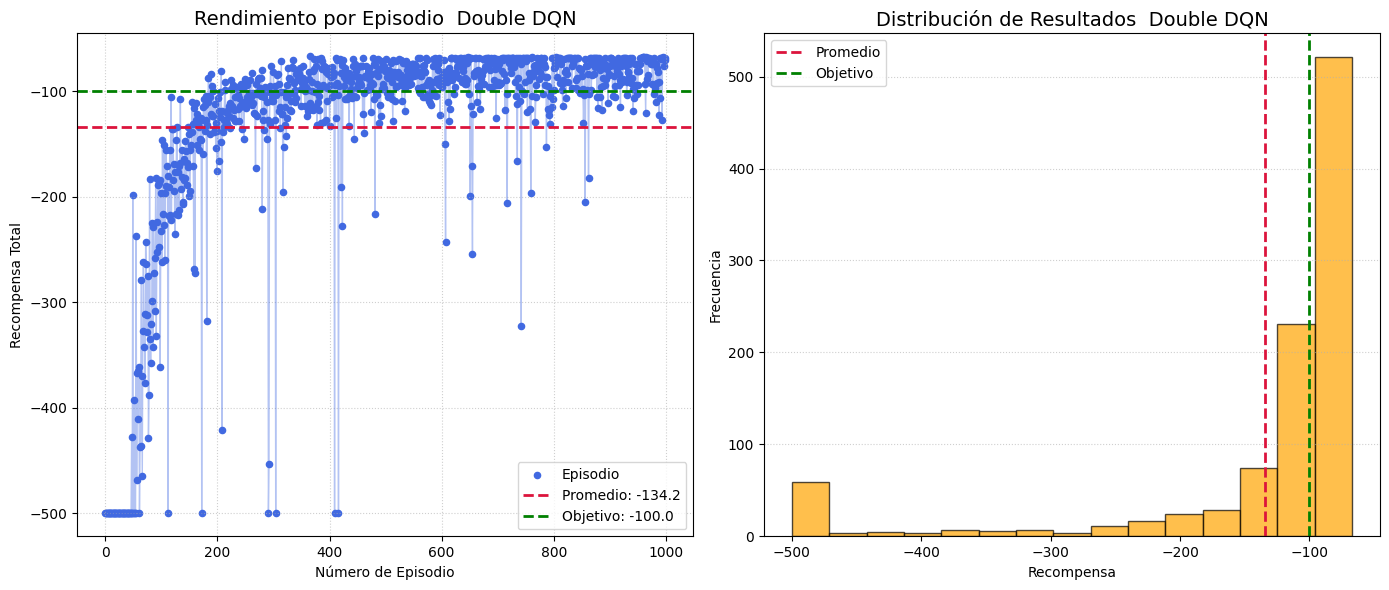

In [3]:
from visualizer import plot_training_results, plot_learning_curve

# OPCIÓN A: El resumen completo (Histograma + Evolución)
plot_training_results(train_rewards, target=-100 , title="Double DQN")

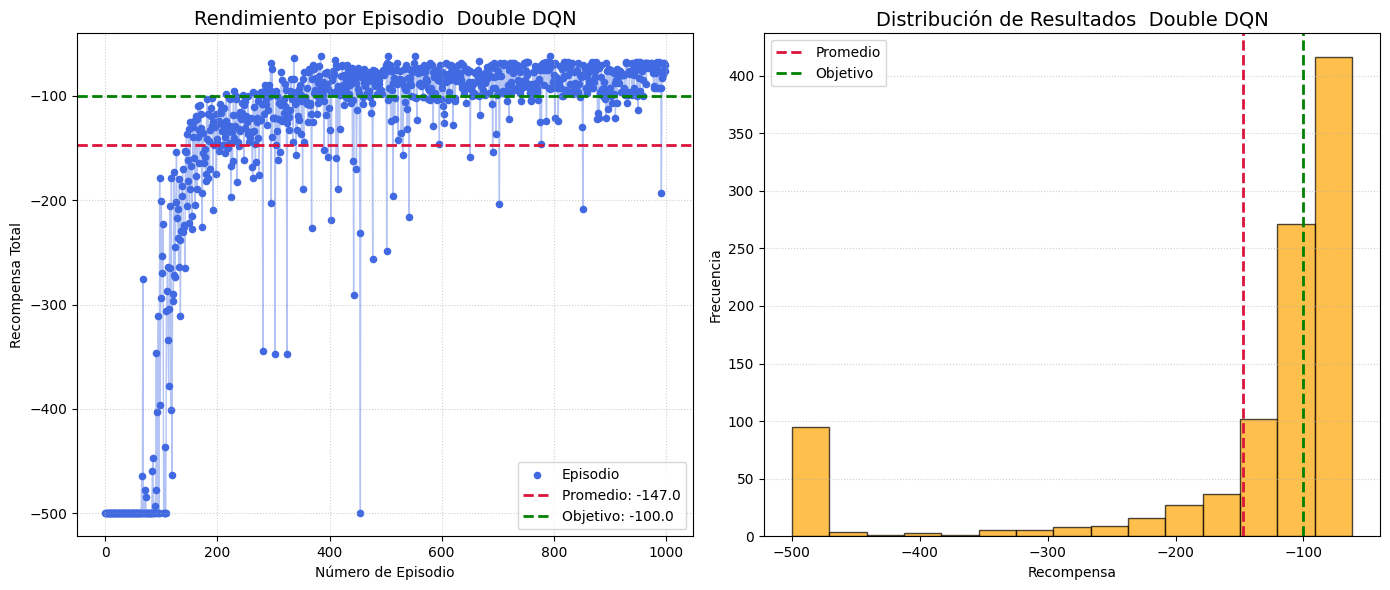

In [3]:
from visualizer import plot_training_results, plot_learning_curve

# OPCIÓN A: El resumen completo (Histograma + Evolución)
plot_training_results(train_rewards, target=-100 , title="Double DQN")

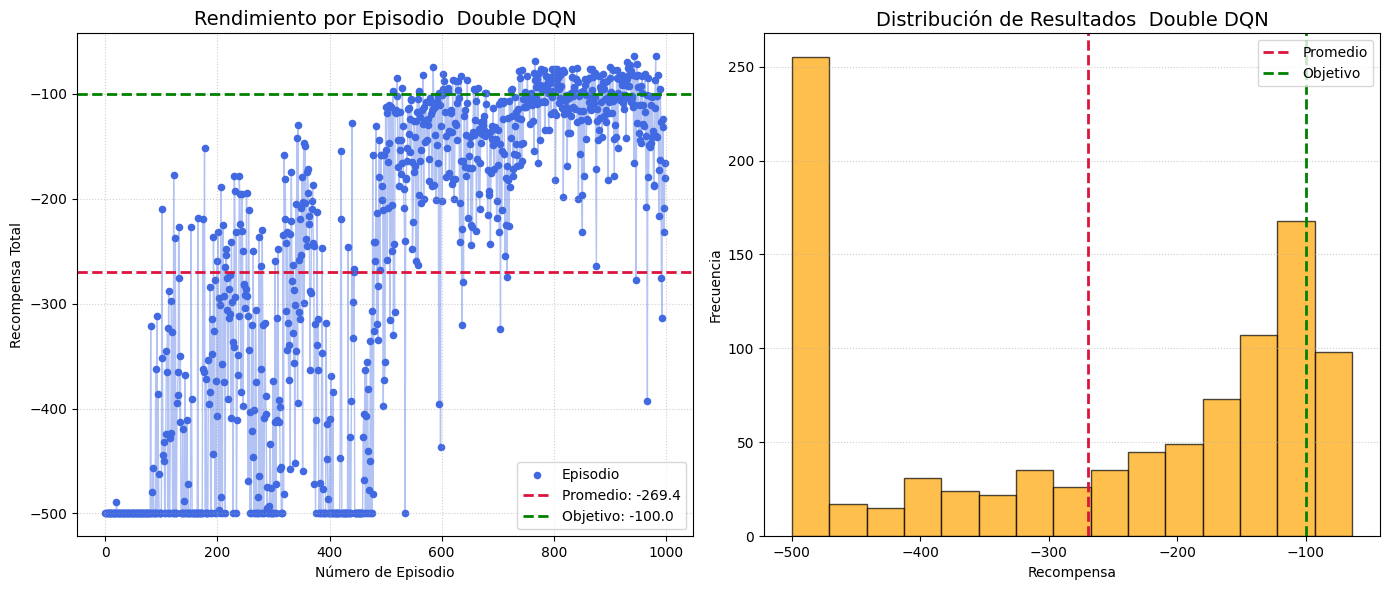

In [3]:
from visualizer import plot_training_results, plot_learning_curve

# OPCIÓN A: El resumen completo (Histograma + Evolución)
plot_training_results(train_rewards, target=-100 , title="Double DQN")

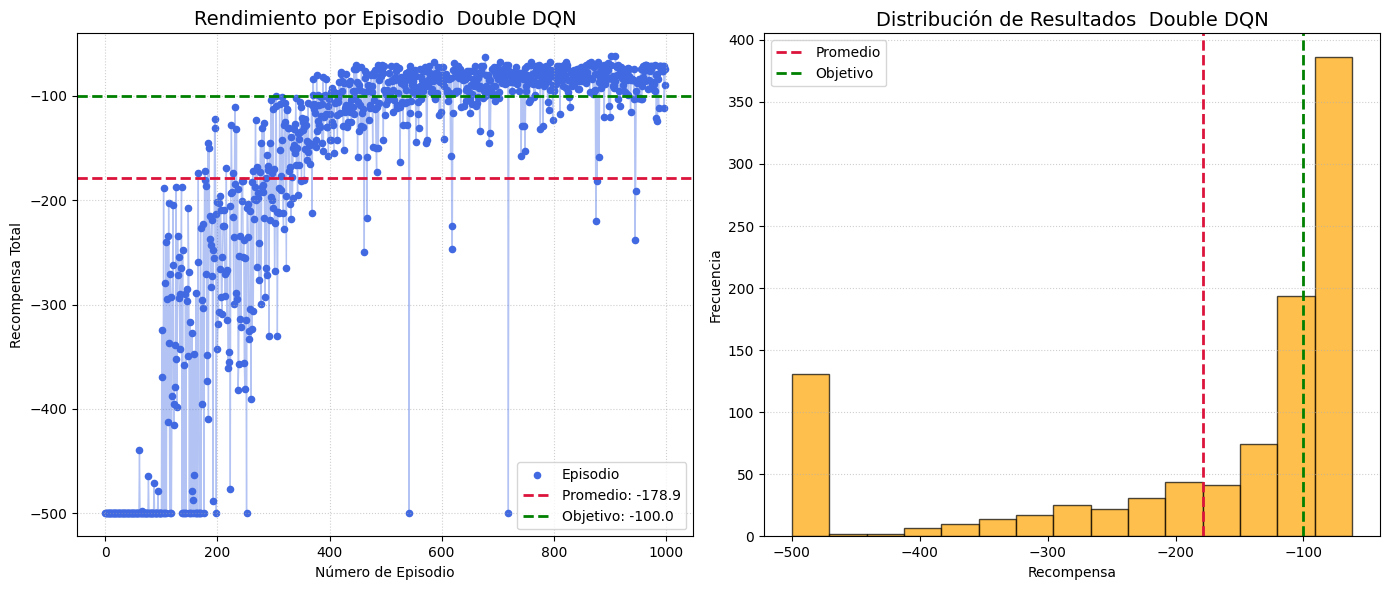

In [4]:
from visualizer import plot_training_results, plot_learning_curve

# OPCIÓN A: El resumen completo (Histograma + Evolución)
plot_training_results(train_rewards, target=-100 , title="Double DQN")

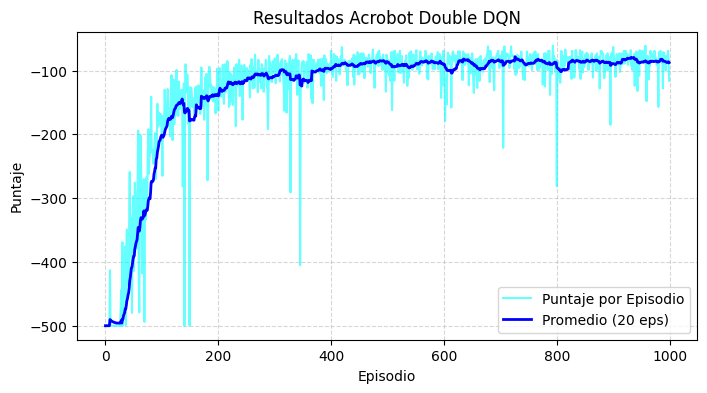

In [7]:
# OPCIÓN B: La curva de aprendizaje clásica (la nueva función)
plot_learning_curve(train_rewards, window_size=20, title="Resultados Acrobot Double DQN")

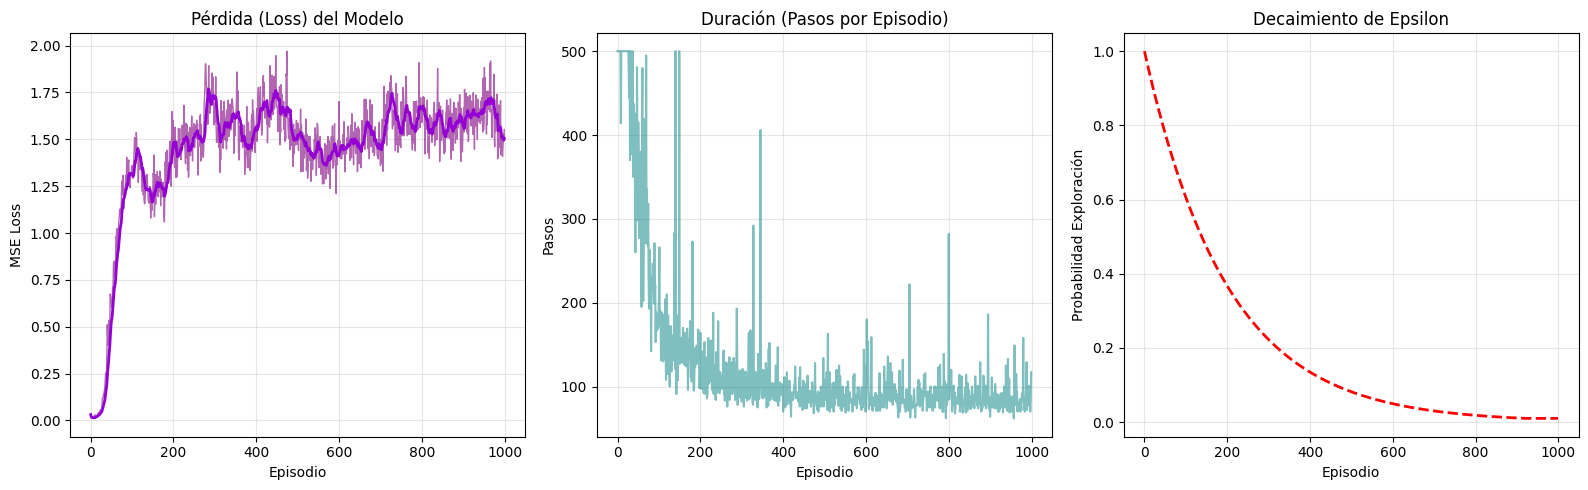

In [8]:
# --- AL FINALIZAR ---
from visualizer import plot_advanced_metrics
plot_advanced_metrics(losses_list, steps_list, epsilons_list)

# Double DQN 64 N - 3K Episodios

In [3]:
# Guardar solo los pesos en un archivo .pth
torch.save(agent.model.state_dict(), "acrobot_ddqn_25-12-3k-64N.pth")
print("¡Modelo guardado exitosamente!")

¡Modelo guardado exitosamente!


In [7]:
np.max(train_rewards)

-61.0

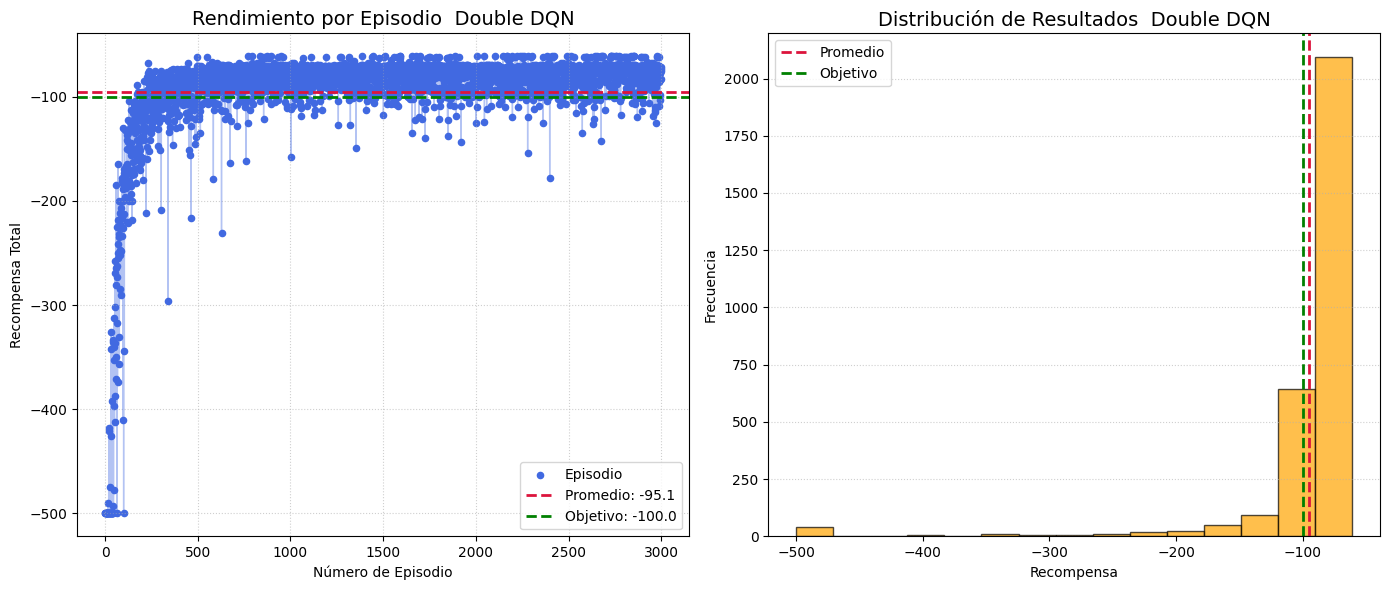

In [4]:
from visualizer import plot_training_results, plot_learning_curve

# OPCIÓN A: El resumen completo (Histograma + Evolución)
plot_training_results(train_rewards, target=-100 , title="Double DQN")

In [8]:
np.max(train_rewards)

-60.0

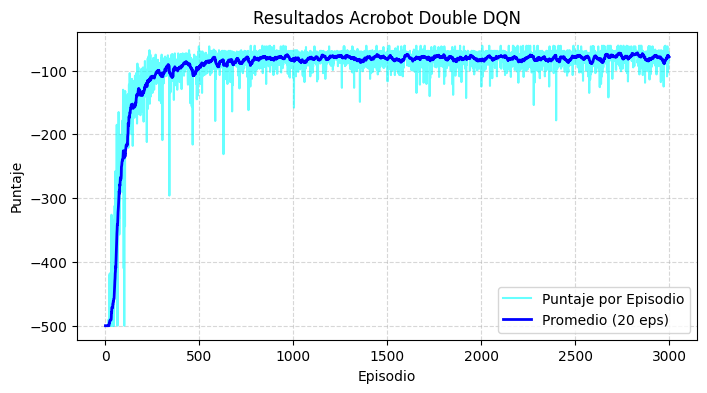

In [5]:
# OPCIÓN B: La curva de aprendizaje clásica (la nueva función)
plot_learning_curve(train_rewards, window_size=20, title="Resultados Acrobot Double DQN")

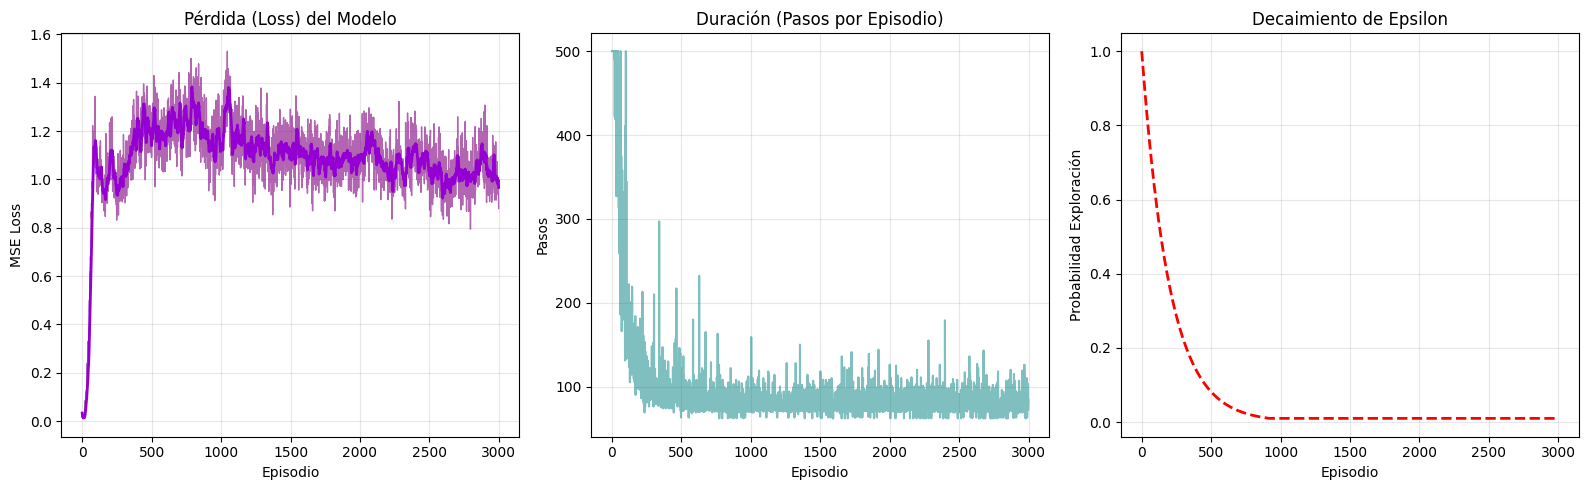

In [6]:
# --- AL FINALIZAR ---
from visualizer import plot_advanced_metrics
plot_advanced_metrics(losses_list, steps_list, epsilons_list)

# Double DQN 64 N - 5K Episodios

In [4]:
# Guardar solo los pesos en un archivo .pth
torch.save(agent.model.state_dict(), "acrobot_ddqn_25-12-5k-64N.pth")
print("¡Modelo guardado exitosamente!")

¡Modelo guardado exitosamente!


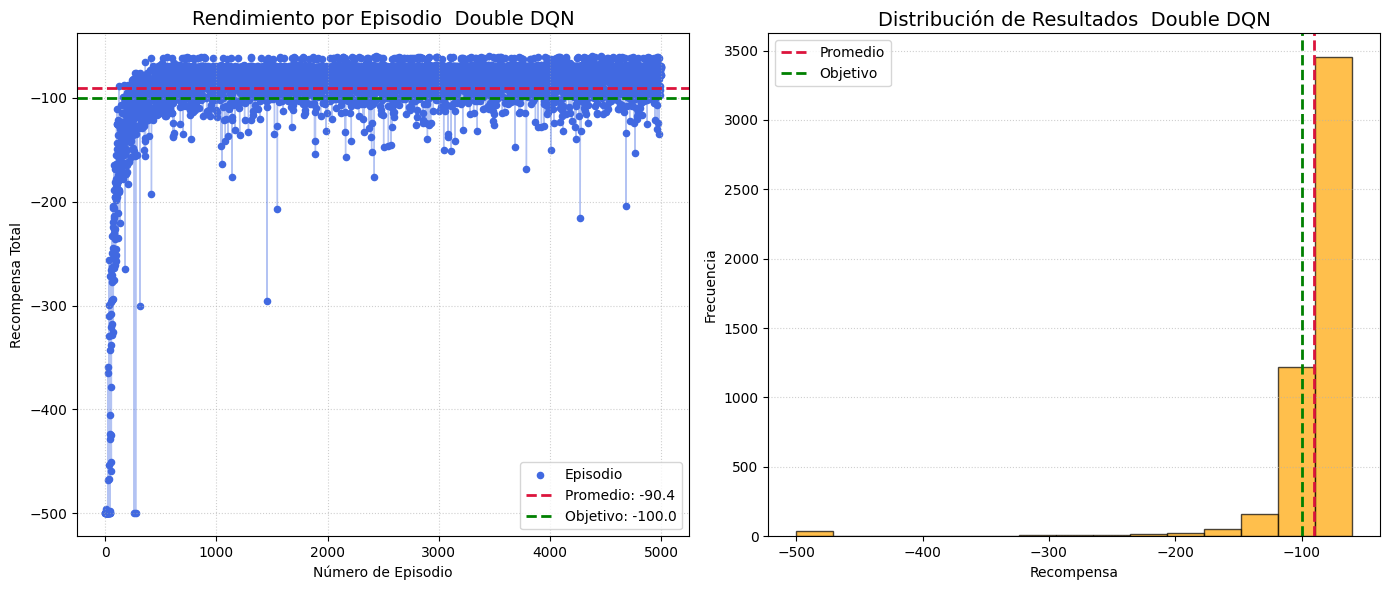

In [5]:
from visualizer import plot_training_results, plot_learning_curve

# OPCIÓN A: El resumen completo (Histograma + Evolución)
plot_training_results(train_rewards, target=-100 , title="Double DQN")

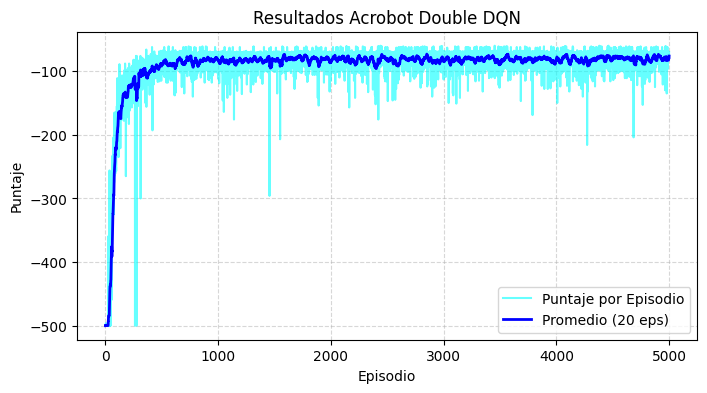

In [6]:
# OPCIÓN B: La curva de aprendizaje clásica (la nueva función)
plot_learning_curve(train_rewards, window_size=20, title="Resultados Acrobot Double DQN")

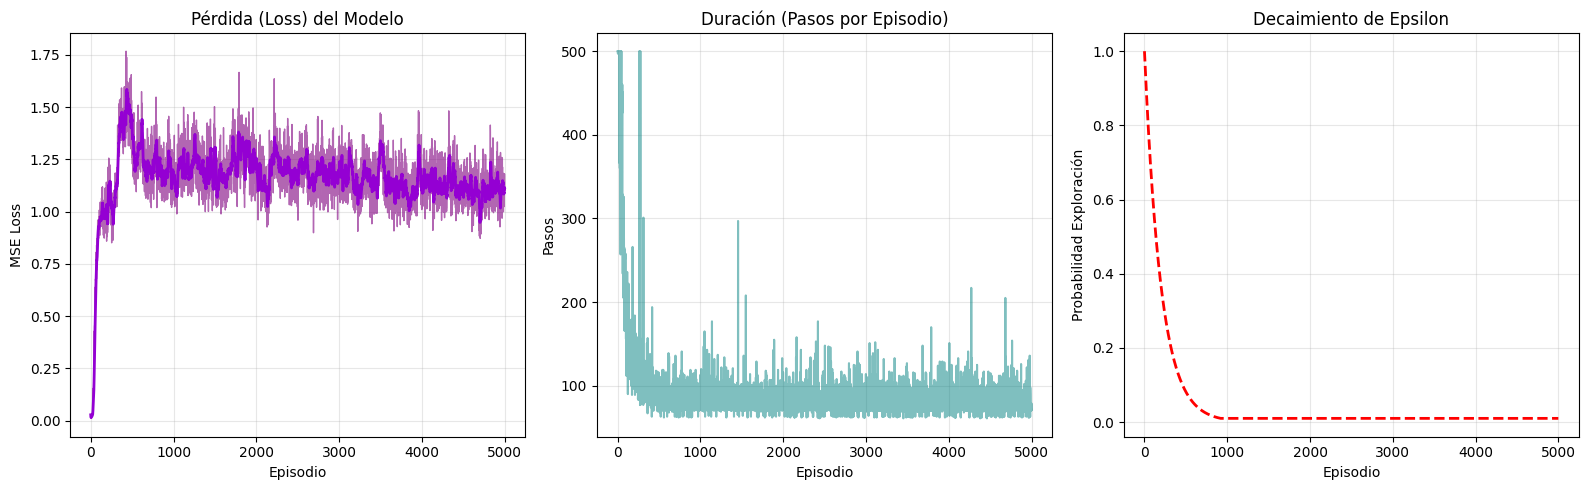

In [7]:
# --- AL FINALIZAR ---
from visualizer import plot_advanced_metrics
plot_advanced_metrics(losses_list, steps_list, epsilons_list)

In [3]:
# Guardar solo los pesos en un archivo .pth
torch.save(agent.model.state_dict(), "acrobot_ddqn_10-01-5k-128N.pth")
print("¡Modelo guardado exitosamente!")

¡Modelo guardado exitosamente!


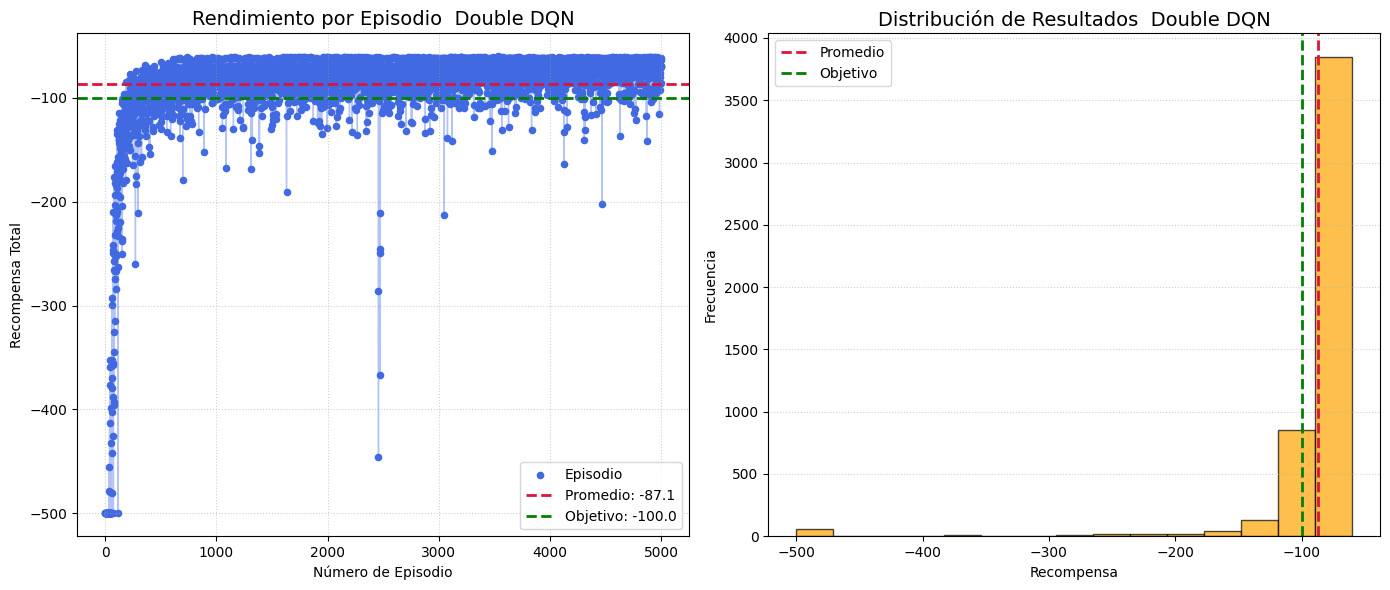

In [5]:
from visualizer import plot_training_results, plot_learning_curve

# OPCIÓN A: El resumen completo (Histograma + Evolución)
plot_training_results(train_rewards, target=-100 , title="Double DQN")

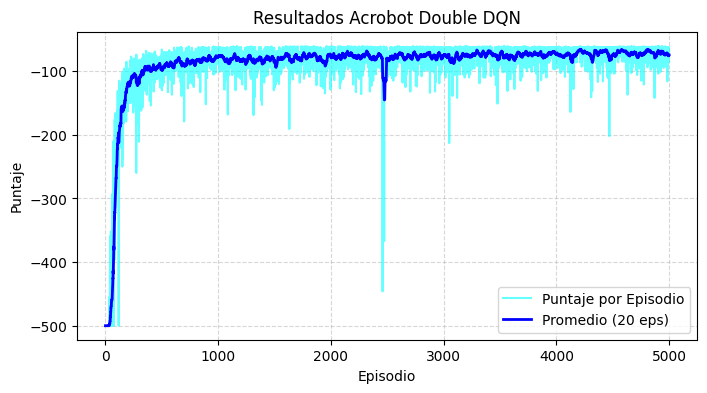

In [6]:
# OPCIÓN B: La curva de aprendizaje clásica (la nueva función)
plot_learning_curve(train_rewards, window_size=20, title="Resultados Acrobot Double DQN")

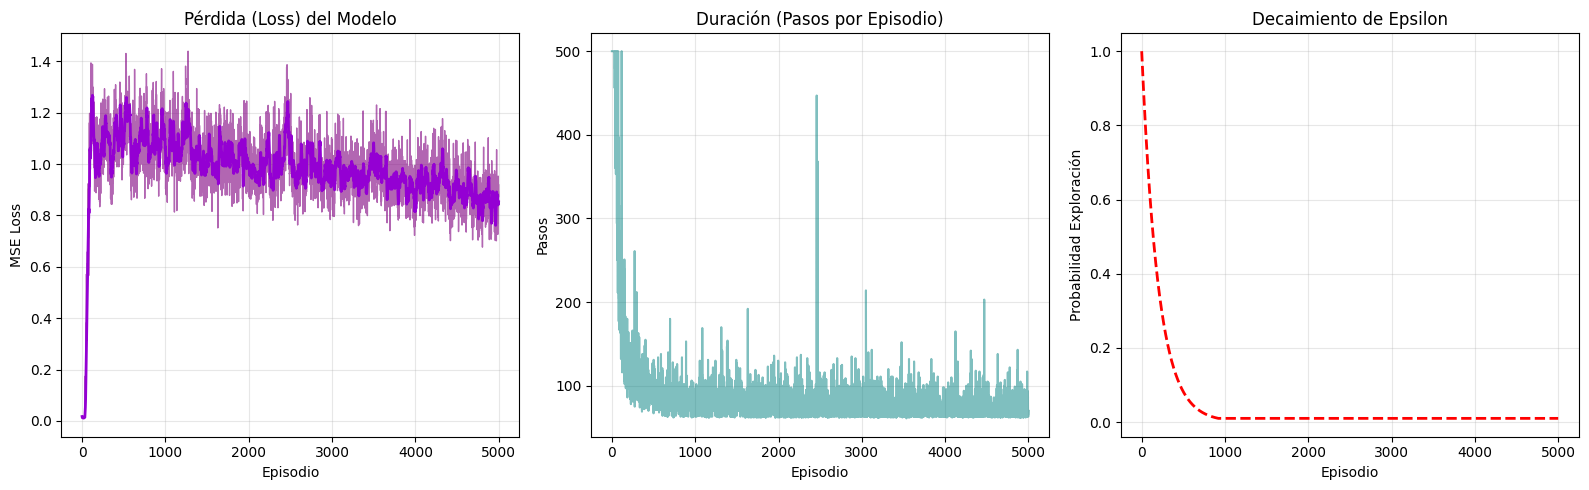

In [7]:
# --- AL FINALIZAR ---
from visualizer import plot_advanced_metrics
plot_advanced_metrics(losses_list, steps_list, epsilons_list)

# Rainbow DQN

In [1]:
import gymnasium as gym
import numpy as np
import torch
from raibow_module import RaibowAgent

# Asegúrate de tener todas las clases anteriores (SumTree, Memory, NoisyLinear, DQN, Agent)
# definidas arriba o importadas de un archivo.
# --- CONFIGURACIÓN ---
ENV_NAME = "Acrobot-v1"
GAMMA = 0.99
#EPSILON = 1.0
#EPSILON_MIN = 0.01
#EPSILON_DECAY = 0.995
LEARNING_RATE = 0.001
BATCH_SIZE = 64
MEMORY_SIZE = 2000000 # 400000
EPISODES = 5000 #1000
TARGET_UPDATE_FREQ = 10  # Actualizar la red objetivo cada 10 episodios
np.random.seed(123)
# 1. Configuración del Entorno
env_name = 'Acrobot-v1' # O 'CartPole-v1'
env = gym.make(env_name)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n

print(f"Iniciando entrenamiento en: {env_name}")
print(f"Estados: {state_size}, Acciones: {action_size}")
# 2. Instanciamos el Agente
# buffer_size alto para tener mucha historia
agent = RaibowAgent(state_size, action_size, 
             lr=LEARNING_RATE, 
             gamma=GAMMA, 
             #epsilon=EPSILON, 
             batch_size=BATCH_SIZE,
             memory_size=MEMORY_SIZE)#(state_size, action_size, buffer_size=10000)

scores = [] # Para guardar el historial de puntos
for e in range(EPISODES):
    # Reiniciar entorno
    state = env.reset(seed=123)
    if isinstance(state, tuple):
        state = state[0]
    
       
    score = 0
    done = False
    
    while True:
        # a. DECIDIR (El agente elige acción basándose en el estado)
        action = agent.act(state)
        
        # b. ACTUAR (Aplicamos la acción al entorno)
        next_state, reward, done, truncated, _ = env.step(action) 
        # Nota: Si usas una versión vieja de gym, quita 'truncated' de la línea de arriba
        
        # c. RECORDAR (Guardamos la experiencia en el SumTree)
        agent.remember(state, action, reward, next_state, done)
        
        # d. APRENDER (El agente entrena con un lote de la memoria)
        loss = agent.replay()
        score += reward
        state = next_state
        if done or truncated:
            scores.append(score)
            break
        
    # Fin del episodio
    #scores.append(score)
    
    
    
    # e. ACTUALIZAR TARGET NETWORK
    # Copiamos los pesos a la red estable cada ciertos episodios
    if e % TARGET_UPDATE_FREQ == 0:
        avg_score = np.mean(scores[-100:]) # Promedio de los últimos 100
        print(f"Episodio: {e+1}/{EPISODES} | Score: {score:.2f} | Avg Score: {avg_score:.2f} | Loss: {loss:.4f}")
        agent.update_target_model()
        print("--- Target Network Actualizada ---")
print("¡Entrenamiento finalizado!")
env.close()


Iniciando entrenamiento en: Acrobot-v1
Estados: 6, Acciones: 3
Episodio: 1/5000 | Score: -281.00 | Avg Score: -281.00 | Loss: 0.0177
--- Target Network Actualizada ---
Episodio: 11/5000 | Score: -500.00 | Avg Score: -406.82 | Loss: 0.0072
--- Target Network Actualizada ---
Episodio: 21/5000 | Score: -500.00 | Avg Score: -451.19 | Loss: 0.0010
--- Target Network Actualizada ---
Episodio: 31/5000 | Score: -500.00 | Avg Score: -455.55 | Loss: 0.0083
--- Target Network Actualizada ---
Episodio: 41/5000 | Score: -500.00 | Avg Score: -444.32 | Loss: 0.0025
--- Target Network Actualizada ---
Episodio: 51/5000 | Score: -500.00 | Avg Score: -411.65 | Loss: 0.0036
--- Target Network Actualizada ---
Episodio: 61/5000 | Score: -500.00 | Avg Score: -415.90 | Loss: 0.0124
--- Target Network Actualizada ---
Episodio: 71/5000 | Score: -374.00 | Avg Score: -420.42 | Loss: 0.0142
--- Target Network Actualizada ---
Episodio: 81/5000 | Score: -401.00 | Avg Score: -427.68 | Loss: 0.0654
--- Target Network 

# Rainbow DQN 64 N -1K Episodios

In [9]:
# Guardar solo los pesos en un archivo .pth
torch.save(agent.model.state_dict(), "acrobot_raibow_27-12-1k-64N.pth")
print("¡Modelo guardado exitosamente!")

¡Modelo guardado exitosamente!


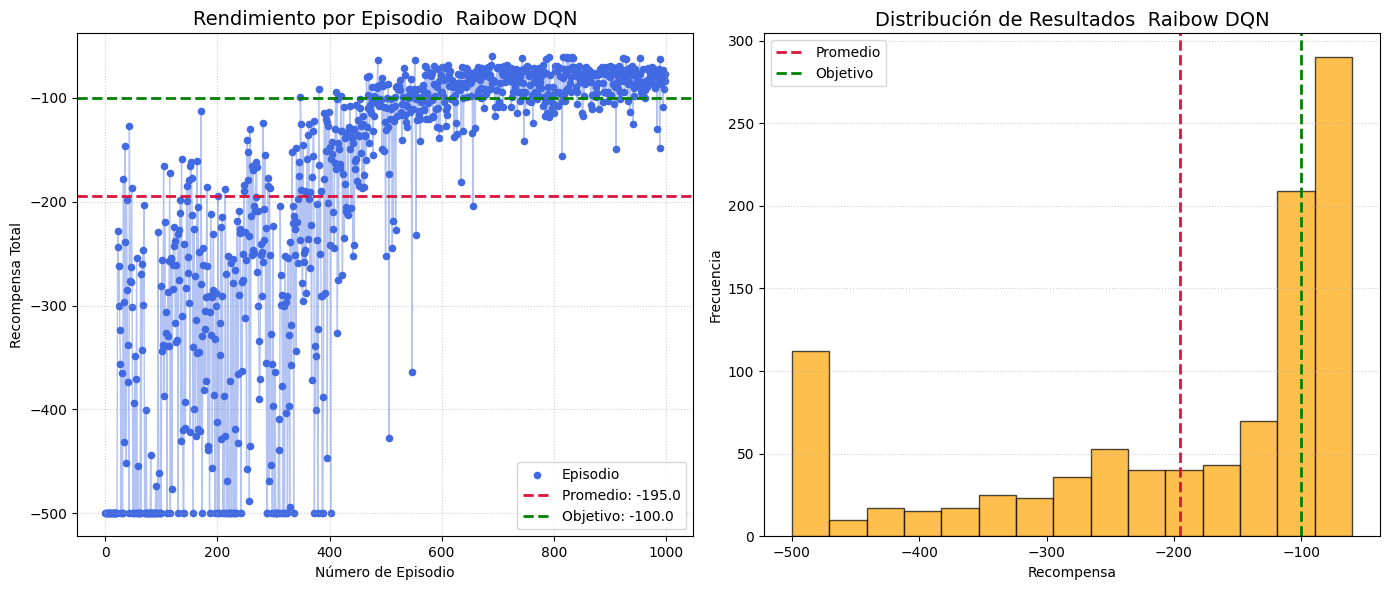

In [2]:
from visualizer import plot_training_results, plot_learning_curve

# OPCIÓN A: El resumen completo (Histograma + Evolución)
plot_training_results(scores, target=-100 , title="Raibow DQN")

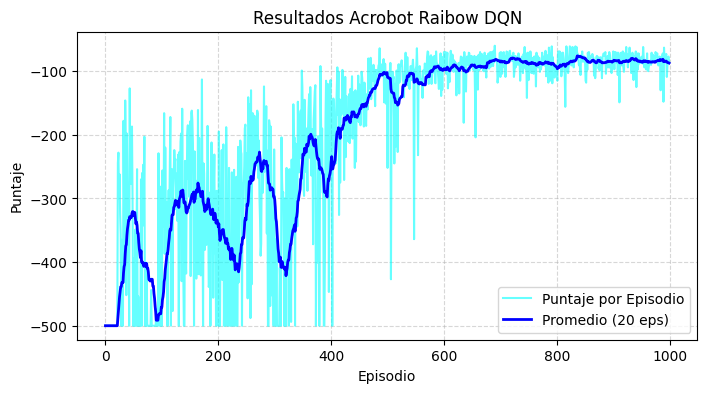

In [8]:
# OPCIÓN B: La curva de aprendizaje clásica (la nueva función)
plot_learning_curve(scores, window_size=20, title="Resultados Acrobot Raibow DQN")

# Rainbow DQN 64 N -3K Episodios

In [11]:
# Guardar solo los pesos en un archivo .pth
torch.save(agent.model.state_dict(), "acrobot_raibow_27-12-3k-64N.pth")
print("¡Modelo guardado exitosamente!")

¡Modelo guardado exitosamente!


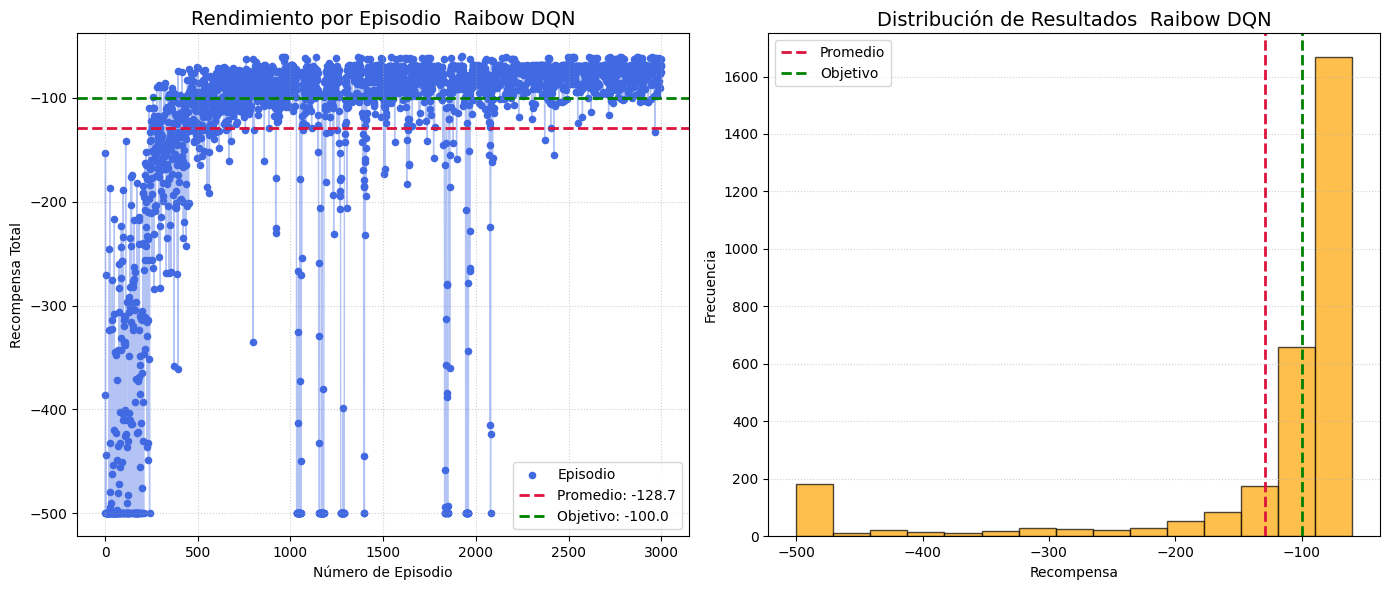

In [12]:
from visualizer import plot_training_results, plot_learning_curve

# OPCIÓN A: El resumen completo (Histograma + Evolución)
plot_training_results(scores, target=-100 , title="Raibow DQN")

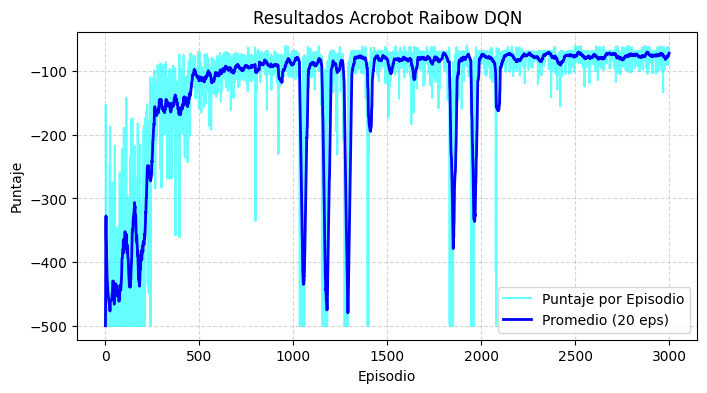

In [13]:
# OPCIÓN B: La curva de aprendizaje clásica (la nueva función)
plot_learning_curve(scores, window_size=20, title="Resultados Acrobot Raibow DQN")

# Rainbow DQN 64 N -5K Episodios

In [4]:
# Guardar solo los pesos en un archivo .pth
torch.save(agent.model.state_dict(), "acrobot_raibow_10-01-5k-64N.pth")
print("¡Modelo guardado exitosamente!")

¡Modelo guardado exitosamente!


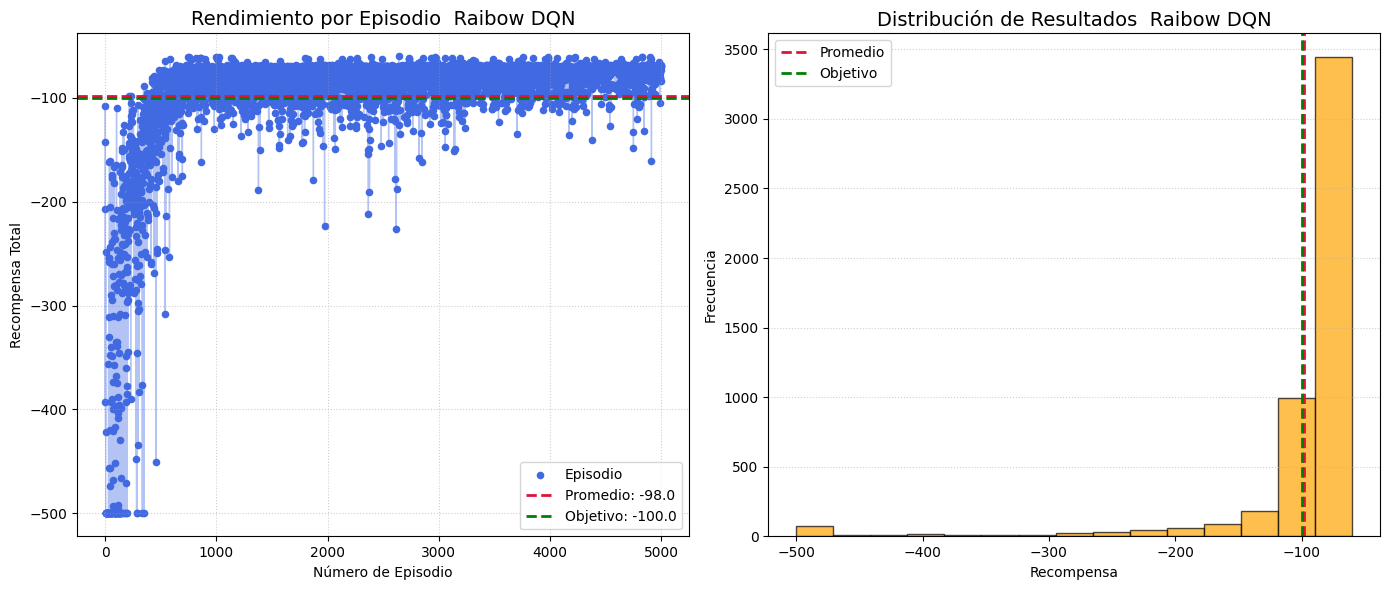

In [5]:
from visualizer import plot_training_results, plot_learning_curve

# OPCIÓN A: El resumen completo (Histograma + Evolución)
plot_training_results(scores, target=-100 , title="Raibow DQN")

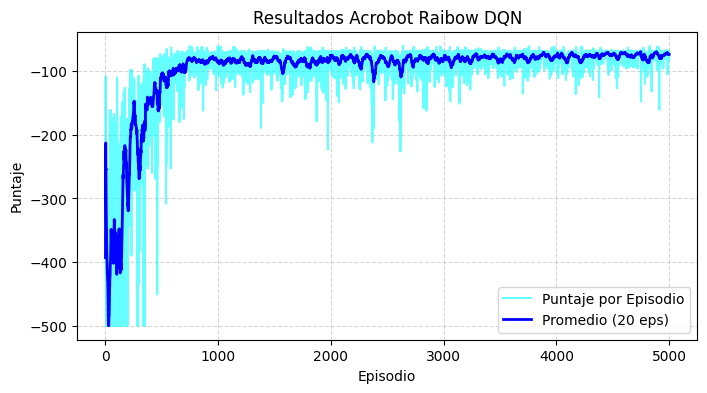

In [6]:
# OPCIÓN B: La curva de aprendizaje clásica (la nueva función)
plot_learning_curve(scores, window_size=20, title="Resultados Acrobot Raibow DQN")

In [2]:
# Guardar solo los pesos en un archivo .pth
torch.save(agent.model.state_dict(), "acrobot_raibow_10-01-5k-128N.pth")
print("¡Modelo guardado exitosamente!")

¡Modelo guardado exitosamente!


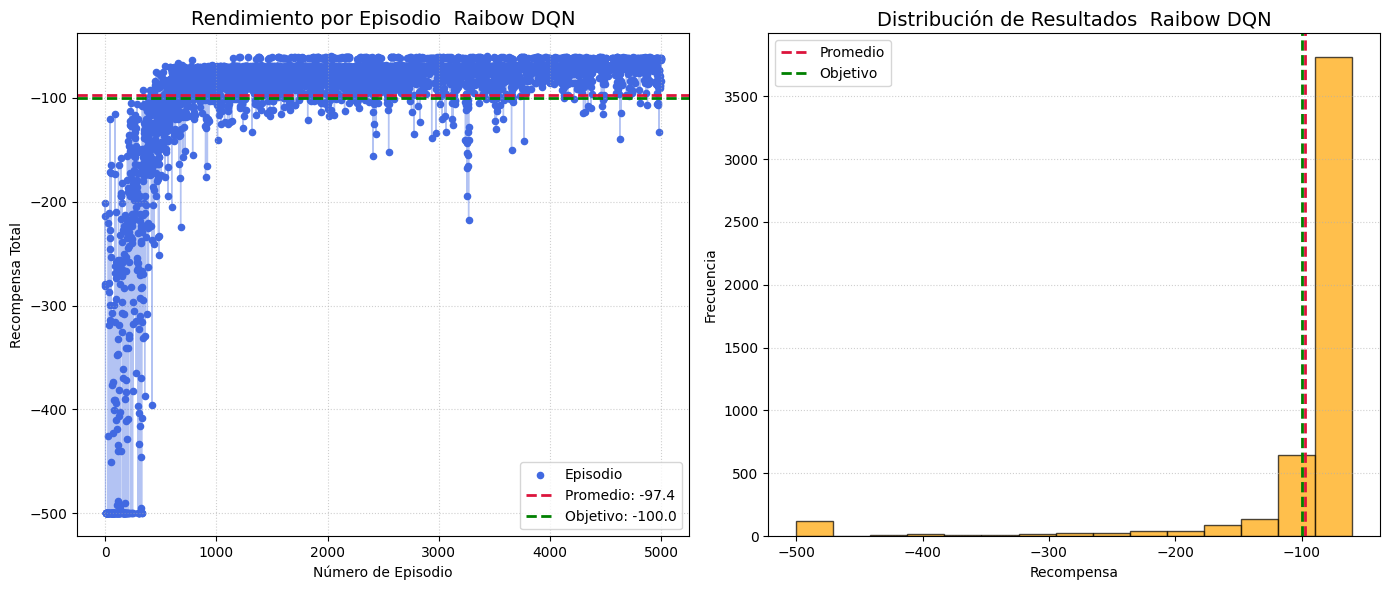

In [3]:
from visualizer import plot_training_results, plot_learning_curve

# OPCIÓN A: El resumen completo (Histograma + Evolución)
plot_training_results(scores, target=-100 , title="Raibow DQN")

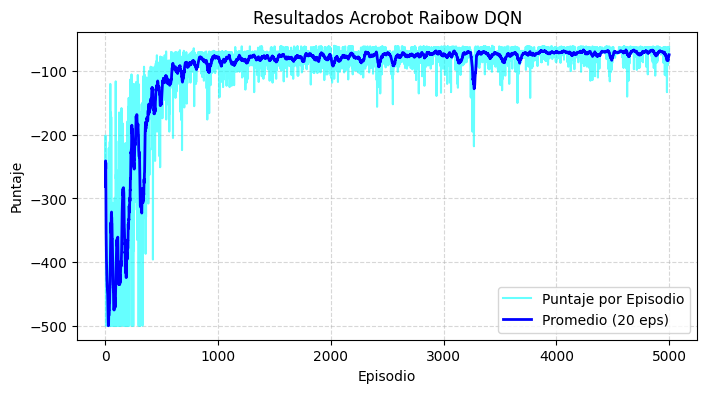

In [4]:
# OPCIÓN B: La curva de aprendizaje clásica (la nueva función)
plot_learning_curve(scores, window_size=20, title="Resultados Acrobot Raibow DQN")

# Comparar modelos 

In [38]:
import gymnasium as gym
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Seteamos la semilla para reproducibilidad
np.random.seed(123)

# --- 1. MISMA ARQUITECTURA ---
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.out = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.out(x)

# --- 2. CONFIGURACIÓN ---
ENV_NAME = "Acrobot-v1"
# Define aquí las rutas de tus 3 modelos
MODEL_PATHS = [
    "acrobot_dqn_25-12-1k-64N.pth",
    "acrobot_dqn_25-12-3k-64N.pth", 
    "acrobot_dqn_25-12-5k-64N.pth"
]
TEST_EPISODES = 100

def evaluate_model(path, env, state_size, action_size):
    """Función para cargar un modelo y evaluar su desempeño."""
    model = DQN(state_size, action_size)
    
    try:
        model.load_state_dict(torch.load(path))
        model.eval()
        print(f"✅ Modelo cargado: {path}")
    except FileNotFoundError:
        print(f"❌ Error: No se encontró {path}. Saltando...")
        return None

    model_scores = []
    
    for e in range(TEST_EPISODES):
        state, _ = env.reset()
        score = 0
        done = False
        truncated = False
        
        while not (done or truncated):
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = model(state_tensor)
                action = np.argmax(q_values.numpy())
            
            next_state, reward, done, truncated, _ = env.step(action)
            state = next_state
            score += reward
            
        model_scores.append(score)
    
    return model_scores

# --- 3. EJECUCIÓN ---
env = gym.make(ENV_NAME)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

results = {}

for path in MODEL_PATHS:
    scores = evaluate_model(path, env, state_size, action_size)
    if scores is not None:
        results[path] = scores
        print(f"   Promedio: {np.mean(scores):.2f}")

env.close()

✅ Modelo cargado: acrobot_dqn_25-12-1k-64N.pth
   Promedio: -96.64
✅ Modelo cargado: acrobot_dqn_25-12-3k-64N.pth
   Promedio: -92.06
✅ Modelo cargado: acrobot_dqn_25-12-5k-64N.pth
   Promedio: -79.05


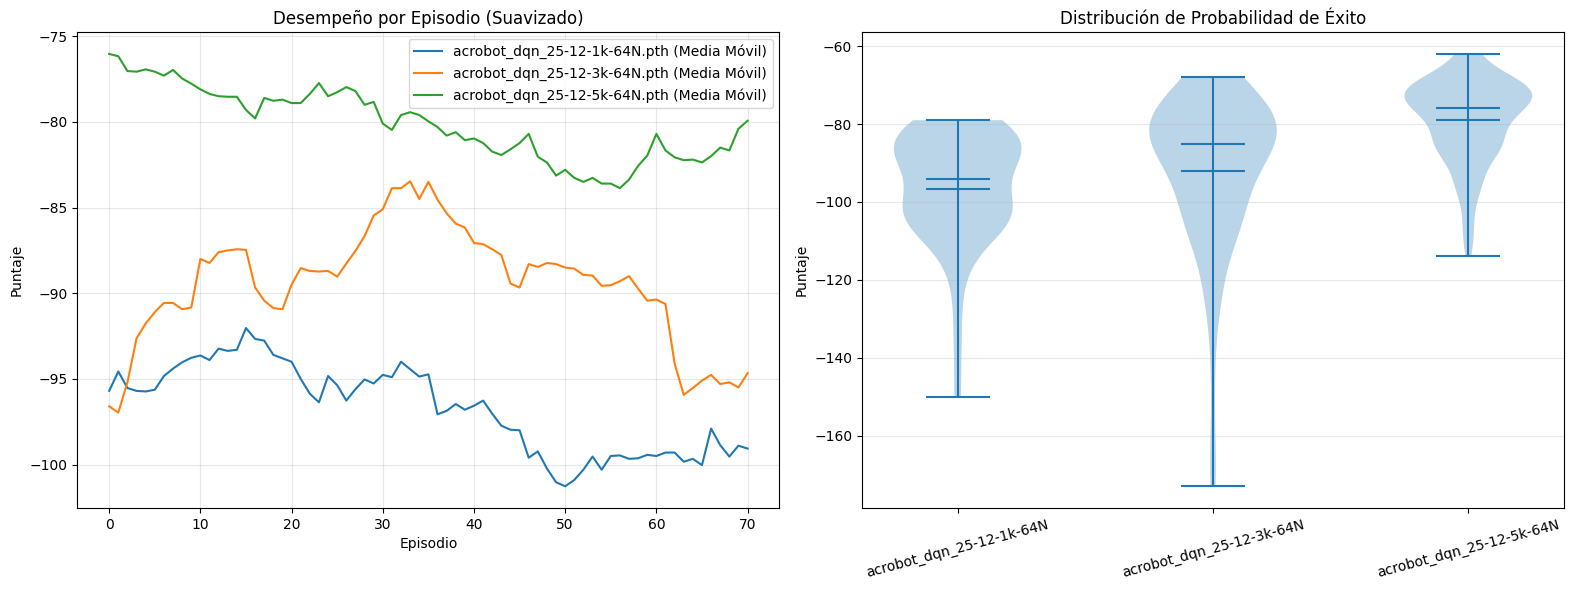


Modelo                         | Promedio   | Mejor      | Peor      
----------------------------------------------------------------------
acrobot_dqn_25-12-1k-64N.pth   | -96.64     | -79.00     | -150.00   
acrobot_dqn_25-12-3k-64N.pth   | -92.06     | -68.00     | -173.00   
acrobot_dqn_25-12-5k-64N.pth   | -79.05     | -62.00     | -114.00   


In [39]:
# --- 4. VISUALIZACIÓN ---

if results:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # A. GRÁFICO DE LÍNEAS (Evolución por episodio)
    for name, scores in results.items():
        # Calculamos una media móvil para que la línea no sea tan ruidosa
        window = 30
        smoothed_scores = np.convolve(scores, np.ones(window)/window, mode='valid')
        ax1.plot(smoothed_scores, label=f"{name} (Media Móvil)")
    
    ax1.set_title(f"Desempeño por Episodio (Suavizado)")
    ax1.set_xlabel("Episodio")
    ax1.set_ylabel("Puntaje")
    #ax1.axhline(y=-500, color='r', linestyle='--', alpha=0.3)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # B. GRÁFICO DE VIOLÍN (Distribución y Densidad)
    # El gráfico de violín es mejor que el boxplot porque muestra dónde se concentran más los puntos
    data_to_plot = list(results.values())
    labels = [n.replace('.pth', '') for n in results.keys()]
    
    parts = ax2.violinplot(data_to_plot, showmeans=True, showmedians=True)
    ax2.set_xticks(range(1, len(labels) + 1))
    ax2.set_xticklabels(labels, rotation=15)
    ax2.set_title("Distribución de Probabilidad de Éxito")
    ax2.set_ylabel("Puntaje")
    ax2.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()
     # Imprimir resumen final
    print("\n" + "="*70)
    print(f"{'Modelo':<30} | {'Promedio':<10} | {'Mejor':<10} | {'Peor':<10}")
    print("-" * 70)
    
    for name, scores in results.items():
        print(f"{name[:30]:<30} | {np.mean(scores):<10.2f} | {np.max(scores):<10.2f} | {np.min(scores):<10.2f}")
    print("="*70)

In [40]:
results_dqn_64=results

In [35]:
import gymnasium as gym
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Seteamos la semilla para reproducibilidad
np.random.seed(123)

# --- 1. MISMA ARQUITECTURA ---
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.out(x)

# --- 2. CONFIGURACIÓN ---
ENV_NAME = "Acrobot-v1"
# Define aquí las rutas de tus 3 modelos
MODEL_PATHS = [
    "acrobot_dqn_25-12-1k-128N.pth",
    "acrobot_dqn_25-12-3k-128N.pth", 
    "acrobot_dqn_25-12-5k-128N.pth"
]
TEST_EPISODES = 100

def evaluate_model(path, env, state_size, action_size):
    """Función para cargar un modelo y evaluar su desempeño."""
    model = DQN(state_size, action_size)
    
    try:
        model.load_state_dict(torch.load(path))
        model.eval()
        print(f"✅ Modelo cargado: {path}")
    except FileNotFoundError:
        print(f"❌ Error: No se encontró {path}. Saltando...")
        return None

    model_scores = []
    
    for e in range(TEST_EPISODES):
        state, _ = env.reset()
        score = 0
        done = False
        truncated = False
        
        while not (done or truncated):
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = model(state_tensor)
                action = np.argmax(q_values.numpy())
            
            next_state, reward, done, truncated, _ = env.step(action)
            state = next_state
            score += reward
            
        model_scores.append(score)
    
    return model_scores

# --- 3. EJECUCIÓN ---
env = gym.make(ENV_NAME)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

results = {}

for path in MODEL_PATHS:
    scores = evaluate_model(path, env, state_size, action_size)
    if scores is not None:
        results[path] = scores
        print(f"   Promedio: {np.mean(scores):.2f}")

env.close()

✅ Modelo cargado: acrobot_dqn_25-12-1k-128N.pth
   Promedio: -92.68
✅ Modelo cargado: acrobot_dqn_25-12-3k-128N.pth
   Promedio: -157.81
✅ Modelo cargado: acrobot_dqn_25-12-5k-128N.pth
   Promedio: -75.27


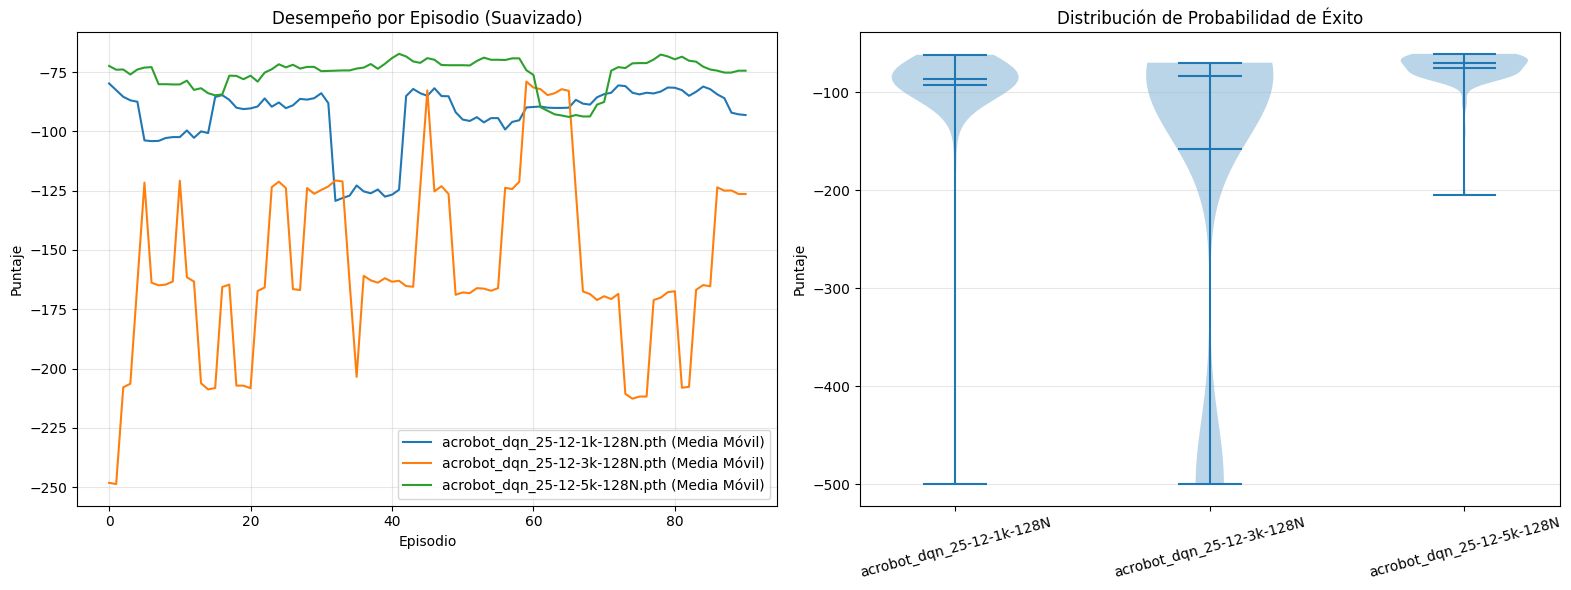


Modelo                         | Promedio   | Mejor      | Peor      
----------------------------------------------------------------------
acrobot_dqn_25-12-1k-128N.pth  | -92.68     | -62.00     | -500.00   
acrobot_dqn_25-12-3k-128N.pth  | -157.81    | -70.00     | -500.00   
acrobot_dqn_25-12-5k-128N.pth  | -75.27     | -61.00     | -205.00   


In [36]:
# --- 4. VISUALIZACIÓN ---

if results:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # A. GRÁFICO DE LÍNEAS (Evolución por episodio)
    for name, scores in results.items():
        # Calculamos una media móvil para que la línea no sea tan ruidosa
        window = 10
        smoothed_scores = np.convolve(scores, np.ones(window)/window, mode='valid')
        ax1.plot(smoothed_scores, label=f"{name} (Media Móvil)")
    
    ax1.set_title(f"Desempeño por Episodio (Suavizado)")
    ax1.set_xlabel("Episodio")
    ax1.set_ylabel("Puntaje")
    #ax1.axhline(y=-500, color='r', linestyle='--', alpha=0.3)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # B. GRÁFICO DE VIOLÍN (Distribución y Densidad)
    # El gráfico de violín es mejor que el boxplot porque muestra dónde se concentran más los puntos
    data_to_plot = list(results.values())
    labels = [n.replace('.pth', '') for n in results.keys()]
    
    parts = ax2.violinplot(data_to_plot, showmeans=True, showmedians=True)
    ax2.set_xticks(range(1, len(labels) + 1))
    ax2.set_xticklabels(labels, rotation=15)
    ax2.set_title("Distribución de Probabilidad de Éxito")
    ax2.set_ylabel("Puntaje")
    ax2.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()
     # Imprimir resumen final
    print("\n" + "="*70)
    print(f"{'Modelo':<30} | {'Promedio':<10} | {'Mejor':<10} | {'Peor':<10}")
    print("-" * 70)
    
    for name, scores in results.items():
        print(f"{name[:30]:<30} | {np.mean(scores):<10.2f} | {np.max(scores):<10.2f} | {np.min(scores):<10.2f}")
    print("="*70)

In [37]:
results_dqn_128=results

In [32]:
import gymnasium as gym
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Seteamos la semilla para reproducibilidad
np.random.seed(123)

# --- 1. MISMA ARQUITECTURA ---
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.out = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.out(x)

# --- 2. CONFIGURACIÓN ---
ENV_NAME = "Acrobot-v1"
# Define aquí las rutas de tus 3 modelos
MODEL_PATHS = [
    "acrobot_ddqn_25-12-1k-64N.pth",
    "acrobot_ddqn_25-12-3k-64N.pth", 
    "acrobot_ddqn_25-12-5k-64N.pth"
]
TEST_EPISODES = 100

def evaluate_model(path, env, state_size, action_size):
    """Función para cargar un modelo y evaluar su desempeño."""
    model = DQN(state_size, action_size)
    
    try:
        model.load_state_dict(torch.load(path))
        model.eval()
        print(f"✅ Modelo cargado: {path}")
    except FileNotFoundError:
        print(f"❌ Error: No se encontró {path}. Saltando...")
        return None

    model_scores = []
    
    for e in range(TEST_EPISODES):
        state, _ = env.reset()
        score = 0
        done = False
        truncated = False
        
        while not (done or truncated):
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = model(state_tensor)
                action = np.argmax(q_values.numpy())
            
            next_state, reward, done, truncated, _ = env.step(action)
            state = next_state
            score += reward
            
        model_scores.append(score)
    
    return model_scores

# --- 3. EJECUCIÓN ---
env = gym.make(ENV_NAME)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

results = {}

for path in MODEL_PATHS:
    scores = evaluate_model(path, env, state_size, action_size)
    if scores is not None:
        results[path] = scores
        print(f"   Promedio: {np.mean(scores):.2f}")

env.close()

✅ Modelo cargado: acrobot_ddqn_25-12-1k-64N.pth
   Promedio: -87.88
✅ Modelo cargado: acrobot_ddqn_25-12-3k-64N.pth
   Promedio: -82.42
✅ Modelo cargado: acrobot_ddqn_25-12-5k-64N.pth
   Promedio: -76.90


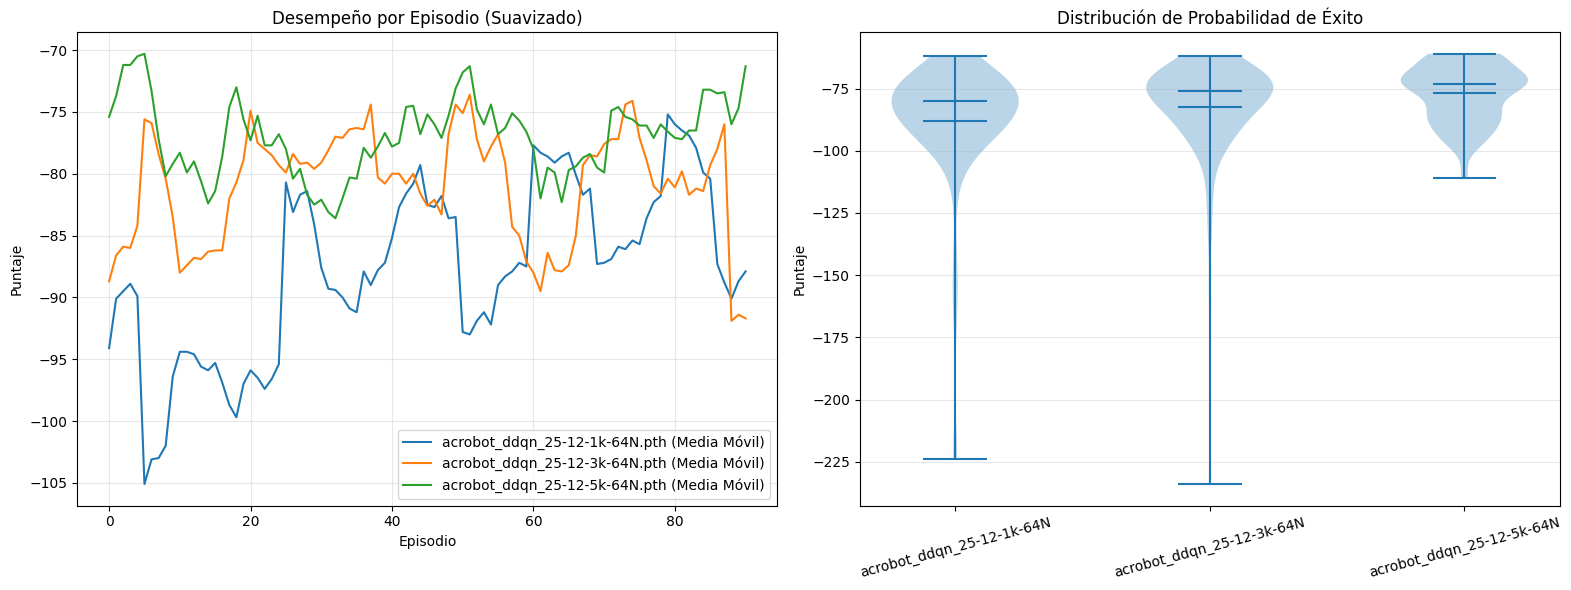


Modelo                         | Promedio   | Mejor      | Peor      
----------------------------------------------------------------------
acrobot_ddqn_25-12-1k-64N.pth  | -87.88     | -62.00     | -224.00   
acrobot_ddqn_25-12-3k-64N.pth  | -82.42     | -62.00     | -234.00   
acrobot_ddqn_25-12-5k-64N.pth  | -76.90     | -61.00     | -111.00   


In [33]:
# --- 4. VISUALIZACIÓN ---

if results:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # A. GRÁFICO DE LÍNEAS (Evolución por episodio)
    for name, scores in results.items():
        # Calculamos una media móvil para que la línea no sea tan ruidosa
        window = 10
        smoothed_scores = np.convolve(scores, np.ones(window)/window, mode='valid')
        ax1.plot(smoothed_scores, label=f"{name} (Media Móvil)")
    
    ax1.set_title(f"Desempeño por Episodio (Suavizado)")
    ax1.set_xlabel("Episodio")
    ax1.set_ylabel("Puntaje")
    #ax1.axhline(y=-500, color='r', linestyle='--', alpha=0.3)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # B. GRÁFICO DE VIOLÍN (Distribución y Densidad)
    # El gráfico de violín es mejor que el boxplot porque muestra dónde se concentran más los puntos
    data_to_plot = list(results.values())
    labels = [n.replace('.pth', '') for n in results.keys()]
    
    parts = ax2.violinplot(data_to_plot, showmeans=True, showmedians=True)
    ax2.set_xticks(range(1, len(labels) + 1))
    ax2.set_xticklabels(labels, rotation=15)
    ax2.set_title("Distribución de Probabilidad de Éxito")
    ax2.set_ylabel("Puntaje")
    ax2.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()
     # Imprimir resumen final
    print("\n" + "="*70)
    print(f"{'Modelo':<30} | {'Promedio':<10} | {'Mejor':<10} | {'Peor':<10}")
    print("-" * 70)
    
    for name, scores in results.items():
        print(f"{name[:30]:<30} | {np.mean(scores):<10.2f} | {np.max(scores):<10.2f} | {np.min(scores):<10.2f}")
    print("="*70)

In [34]:
results_ddqn_64=results

In [80]:
import gymnasium as gym
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Seteamos la semilla para reproducibilidad
np.random.seed(123)

# --- 1. MISMA ARQUITECTURA ---
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.out(x)

# --- 2. CONFIGURACIÓN ---
ENV_NAME = "Acrobot-v1"
# Define aquí las rutas de tus 3 modelos
MODEL_PATHS = [
    "acrobot_ddqn_10-01-5k-128N.pth"
]
TEST_EPISODES = 100

def evaluate_model(path, env, state_size, action_size):
    """Función para cargar un modelo y evaluar su desempeño."""
    model = DQN(state_size, action_size)
    
    try:
        model.load_state_dict(torch.load(path))
        model.eval()
        print(f"✅ Modelo cargado: {path}")
    except FileNotFoundError:
        print(f"❌ Error: No se encontró {path}. Saltando...")
        return None

    model_scores = []
    
    for e in range(TEST_EPISODES):
        state, _ = env.reset()
        score = 0
        done = False
        truncated = False
        
        while not (done or truncated):
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = model(state_tensor)
                action = np.argmax(q_values.numpy())
            
            next_state, reward, done, truncated, _ = env.step(action)
            state = next_state
            score += reward
            
        model_scores.append(score)
    
    return model_scores

# --- 3. EJECUCIÓN ---
env = gym.make(ENV_NAME)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

results = {}

for path in MODEL_PATHS:
    scores = evaluate_model(path, env, state_size, action_size)
    if scores is not None:
        results[path] = scores
        print(f"   Promedio: {np.mean(scores):.2f}")

env.close()

✅ Modelo cargado: acrobot_ddqn_10-01-5k-128N.pth
   Promedio: -65.94


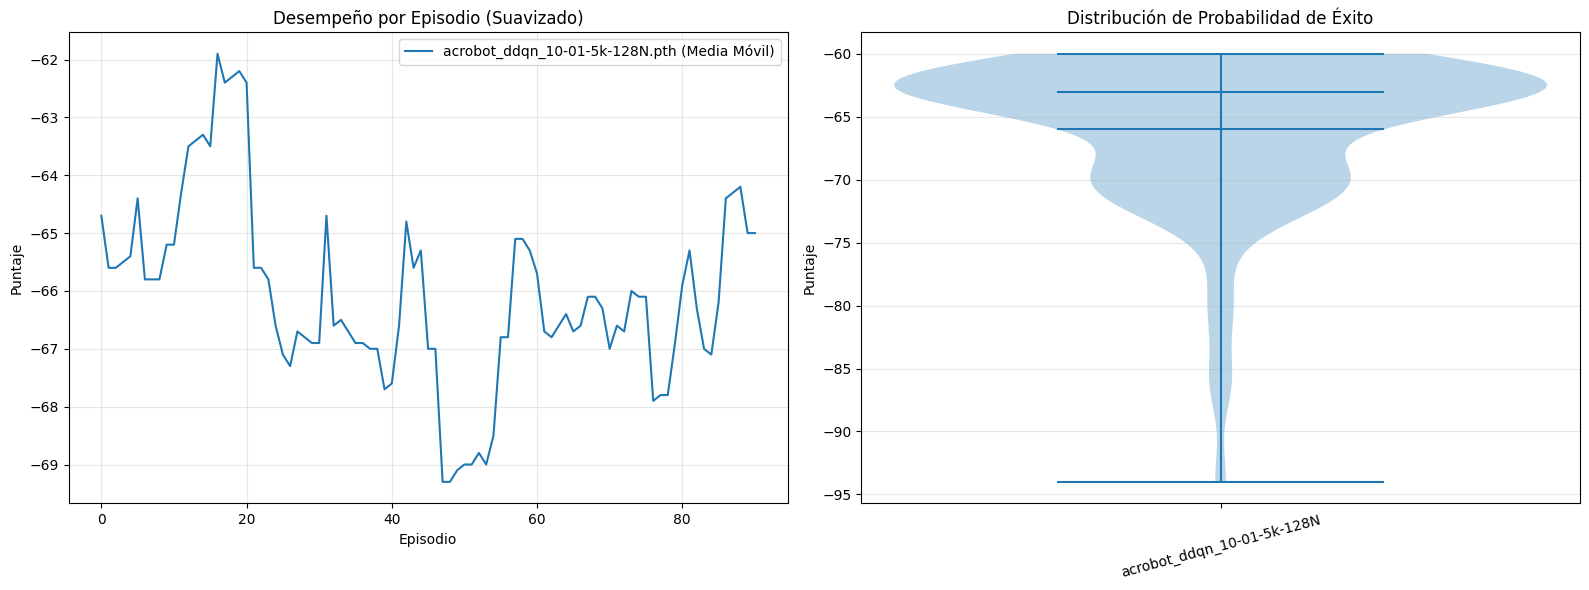


Modelo                         | Promedio   | Mejor      | Peor      
----------------------------------------------------------------------
acrobot_ddqn_10-01-5k-128N.pth | -65.94     | -60.00     | -94.00    


In [81]:
# --- 4. VISUALIZACIÓN ---

if results:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # A. GRÁFICO DE LÍNEAS (Evolución por episodio)
    for name, scores in results.items():
        # Calculamos una media móvil para que la línea no sea tan ruidosa
        window = 10
        smoothed_scores = np.convolve(scores, np.ones(window)/window, mode='valid')
        ax1.plot(smoothed_scores, label=f"{name} (Media Móvil)")
    
    ax1.set_title(f"Desempeño por Episodio (Suavizado)")
    ax1.set_xlabel("Episodio")
    ax1.set_ylabel("Puntaje")
    #ax1.axhline(y=-500, color='r', linestyle='--', alpha=0.3)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # B. GRÁFICO DE VIOLÍN (Distribución y Densidad)
    # El gráfico de violín es mejor que el boxplot porque muestra dónde se concentran más los puntos
    data_to_plot = list(results.values())
    labels = [n.replace('.pth', '') for n in results.keys()]
    
    parts = ax2.violinplot(data_to_plot, showmeans=True, showmedians=True)
    ax2.set_xticks(range(1, len(labels) + 1))
    ax2.set_xticklabels(labels, rotation=15)
    ax2.set_title("Distribución de Probabilidad de Éxito")
    ax2.set_ylabel("Puntaje")
    ax2.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()
     # Imprimir resumen final
    print("\n" + "="*70)
    print(f"{'Modelo':<30} | {'Promedio':<10} | {'Mejor':<10} | {'Peor':<10}")
    print("-" * 70)
    
    for name, scores in results.items():
        print(f"{name[:30]:<30} | {np.mean(scores):<10.2f} | {np.max(scores):<10.2f} | {np.min(scores):<10.2f}")
    print("="*70)

In [82]:
results_ddqn_128=results

In [83]:
result_agg= {}
result_agg['acrobot_dqn_25-12-5k-64N.pth'] = results_dqn_64['acrobot_dqn_25-12-5k-64N.pth']
result_agg['acrobot_dqn_25-12-5k-128N.pth'] = results_dqn_128['acrobot_dqn_25-12-5k-128N.pth']
result_agg['acrobot_ddqn_25-12-5k-64N.pth'] = results_ddqn_64['acrobot_ddqn_25-12-5k-64N.pth']
result_agg['acrobot_ddqn_10-01-5k-128N.pth'] = results_ddqn_128['acrobot_ddqn_10-01-5k-128N.pth']

In [55]:
result_agg

{'acrobot_ddqn_25-12-5k-64N.pth': [-90.0,
  -96.0,
  -62.0,
  -77.0,
  -85.0,
  -69.0,
  -71.0,
  -62.0,
  -71.0,
  -71.0,
  -73.0,
  -71.0,
  -62.0,
  -70.0,
  -83.0,
  -99.0,
  -110.0,
  -92.0,
  -61.0,
  -62.0,
  -89.0,
  -62.0,
  -78.0,
  -88.0,
  -73.0,
  -71.0,
  -70.0,
  -76.0,
  -87.0,
  -79.0,
  -69.0,
  -86.0,
  -78.0,
  -79.0,
  -85.0,
  -95.0,
  -62.0,
  -97.0,
  -95.0,
  -75.0,
  -79.0,
  -91.0,
  -62.0,
  -62.0,
  -86.0,
  -70.0,
  -70.0,
  -88.0,
  -84.0,
  -86.0,
  -76.0,
  -62.0,
  -61.0,
  -85.0,
  -70.0,
  -78.0,
  -81.0,
  -70.0,
  -62.0,
  -73.0,
  -71.0,
  -97.0,
  -73.0,
  -69.0,
  -94.0,
  -73.0,
  -69.0,
  -76.0,
  -71.0,
  -87.0,
  -111.0,
  -72.0,
  -77.0,
  -93.0,
  -68.0,
  -70.0,
  -62.0,
  -73.0,
  -82.0,
  -91.0,
  -61.0,
  -69.0,
  -85.0,
  -95.0,
  -73.0,
  -70.0,
  -72.0,
  -62.0,
  -88.0,
  -96.0,
  -62.0,
  -62.0,
  -85.0,
  -62.0,
  -73.0,
  -73.0,
  -71.0,
  -88.0,
  -75.0,
  -62.0],
 'acrobot_ddqn_10-01-5k-128N.pth': [-70.0,
  -63.0,
  -62.0,
  -

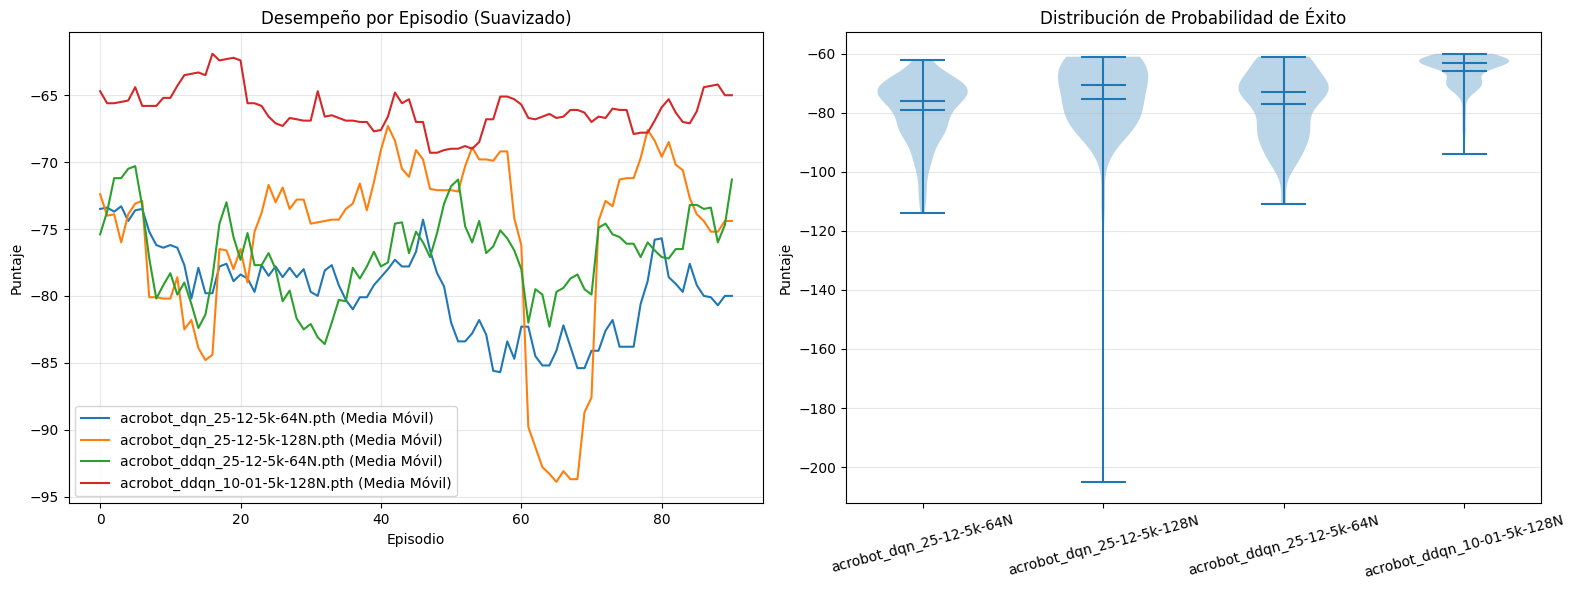


Ranking  | Modelo                         | Promedio   | Mejor      | Peor      
--------------------------------------------------------------------------------
#1       | acrobot_ddqn_10-01-5k-128N.pth | -65.94     | -60.00     | -94.00    
#2       | acrobot_dqn_25-12-5k-128N.pth  | -75.27     | -61.00     | -205.00   
#3       | acrobot_ddqn_25-12-5k-64N.pth  | -76.90     | -61.00     | -111.00   
#4       | acrobot_dqn_25-12-5k-64N.pth   | -79.05     | -62.00     | -114.00   


In [84]:
# --- 4. VISUALIZACIÓN ---

if result_agg:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # A. GRÁFICO DE LÍNEAS (Evolución por episodio)
    for name, scores in result_agg.items():
        # Calculamos una media móvil para que la línea no sea tan ruidosa
        window = 10
        smoothed_scores = np.convolve(scores, np.ones(window)/window, mode='valid')
        ax1.plot(smoothed_scores, label=f"{name} (Media Móvil)")
    
    ax1.set_title(f"Desempeño por Episodio (Suavizado)")
    ax1.set_xlabel("Episodio")
    ax1.set_ylabel("Puntaje")
    #ax1.axhline(y=-500, color='r', linestyle='--', alpha=0.3)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # B. GRÁFICO DE VIOLÍN (Distribución y Densidad)
    # El gráfico de violín es mejor que el boxplot porque muestra dónde se concentran más los puntos
    data_to_plot = list(result_agg.values())
    labels = [n.replace('.pth', '') for n in result_agg.keys()]
    
    parts = ax2.violinplot(data_to_plot, showmeans=True, showmedians=True)
    ax2.set_xticks(range(1, len(labels) + 1))
    ax2.set_xticklabels(labels, rotation=15)
    ax2.set_title("Distribución de Probabilidad de Éxito")
    ax2.set_ylabel("Puntaje")
    ax2.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()
    
    # --- 5. RESUMEN FINAL ORDENADO ---
print("\n" + "="*80)
print(f"{'Ranking':<8} | {'Modelo':<30} | {'Promedio':<10} | {'Mejor':<10} | {'Peor':<10}")
print("-" * 80)

# 1. Convertimos el diccionario a una lista de items y la ordenamos
# Usamos np.mean(x[1]) como clave, donde x[1] son los scores
sorted_results = sorted(result_agg.items(), key=lambda x: np.mean(x[1]), reverse=True)

# 2. Iteramos sobre la lista ya ordenada
for i, (name, scores) in enumerate(sorted_results, 1):
    mean_s = np.mean(scores)
    max_s = np.max(scores)
    min_s = np.min(scores)
    # Imprimimos con formato de tabla
    print(f"#{i:<7} | {name[:30]:<30} | {mean_s:<10.2f} | {max_s:<10.2f} | {min_s:<10.2f}")

print("="*80)